## <b> Modelling HDB Resale Prices </b>
---
### <b> Notebook 1: Exploratory Data Analysis (EDA) </b>
---

<b> Project Overview / Objectives </b>

* Build a model that predicts the resale price of public housing (i.e., Housing Development Board (HDB)) apartments in Singapore
    * Evaluate the model's predictive ability against unseen "test" data, via a Kaggle submission
* Separably identify key features associated with resale prices - by quantifying their importance from a statistical and practical viewpoint


<br>
<b> Notebook Overview </b>

* The codes in this notebook provide a high-level overview of the data. 
* In addition, the codes perform preliminary, descriptive analyses to:
    * (a) examine support for hypotheses regarding features influencing resale prices
    * (b) aid with conceptualising cleaning codes and features to engineer

<br>
<b> Notebook Structure </b>

* Part 1: Data Overview
* Part 2: Define EDA Functions
* Part 3: Hypothesis Formation, EDA, Conceptualisation of Cleaning Codes & Features to Engineer
* Part 4: Summary of Data Processing Next Steps

<br>


---

#### <b> Part 1: Data Overview </b>

<b>(a) Imports / Installations</b>

In [1]:
# Import Libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

<b>(b) Available Data Scan - No. of Observations, No. of Data Columns, Time Period</b>

<u>HDB Resale Price Dataset</u>

*  Data on HDB resale prices over ~ 9 years (2012-03 to 2021-04), split into:

    * <b>Training Dataset</b> [train.csv]: ~ 150,000 observations (resale price data: present)
    * <b>Testing Dataset</b> [test.csv]: ~ 16,500 observations   (resale price data: masked)
        * *Resale price data has been intentionally masked*
        * *Procedurally, a trained model is meant to be applied on the "kaggle testing" dataset, and its performance evaluated via a Kaggle submission*

*  Data on a wide range of housing attributes comprising over 70 data columns, covering the following broad attribute categories:

    * Apartments' individual physical characteristics
    * Apartments' individual remaining lease period
    * Apartments' housing block characteristics
    * Surrounding transport infrastructure
    * Surrounding amenities
    * Surrounding schools

* Data Source: [Kaggle. General Assembly "DSI-SG Project 2 Regression Challenge (HDB Price)"](https://www.kaggle.com/competitions/dsi-sg-project-2-regression-challenge-hdb-price/data)


In [2]:
### Available Data Scan: Test & Train Data

# [1] Load Datasets & Convert Variable Names to Lowercase
df_test  = pd.read_csv("1_Data/test.csv", dtype={40:str})
df_train = pd.read_csv("1_Data/train.csv", dtype={41:str})

# Iterate Process: Test & Train Datasets

data = {"Data: Test":df_test, "Data: Train":df_train}

for data_name, df in data.items():

    # [2] Convert Variable Names to Lowercase
    df.columns = df.columns.str.lower()

    # [3] No. of Observations & Data Columns
    print("")
    print(f"=== {data_name} ===")
    print("No. of observations:", df.shape[0])
    print("No. of data columns:", df.shape[1]) # exclude resale prices (based on data dictionary hosted on kaggle)

    # [4] Time Period

    # Add: "tranc_yr_mth", "tranc_yr" and "tranc_mth" as numeric columns from "Tranc_YearMonth"
    df["tranc_yr_mth"] = (df["tranc_yearmonth"].str[0:4].astype(int))*100 + (df["tranc_yearmonth"].str[5:7].astype(int))
    df["tranc_yr"]     = (df["tranc_yearmonth"].str[0:4].astype(int))
    df["tranc_mth"]    = (df["tranc_yearmonth"].str[5:7].astype(int))

    # Examine: Range of Year-Months
    print("\nTransaction Years & Months for Which Data Are Available:\n")
    print(df.sort_values(by=["tranc_mth"], ascending=True).groupby(by="tranc_yr")["tranc_mth"].unique())



=== Data: Test ===
No. of observations: 16737
No. of data columns: 76

Transaction Years & Months for Which Data Are Available:

tranc_yr
2012          [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
2013    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
2014    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
2015    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
2016    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
2017    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
2018    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
2019    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
2020    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
2021                               [1, 2, 3, 4]
Name: tranc_mth, dtype: object

=== Data: Train ===
No. of observations: 150634
No. of data columns: 77

Transaction Years & Months for Which Data Are Available:

tranc_yr
2012          [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
2013    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
2014    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
2015    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
2016    [1, 2, 3,


---

#### <b> Part 2: Define EDA Functions </b>

<b>(1) Define a function that returns quintile positions from a range of continuous values</b>

In [3]:
def conti_to_quintile(data):
    quintile_labels = ["q1", "q2", "q3", "q4", "q5"]
    quintile = pd.qcut(data, q=[0, 0.2, 0.4, 0.6, 0.8, 1], precision=0, labels=quintile_labels)
    return quintile


---

#### <b> Part 3: Hypothesis Formation, EDA, Conceptualisation of Cleaning Codes & Features to Engineer </b>

<b> Background Note </b>

* The process of (i) formulating hypotheses about factors associated with HDB resale prices, and (ii) conceptualising features to engineer to test these hypotheses were guided by:

    * An interview with a practicing property agent 
    * A review of the literature: covering research papers, op-eds, and newspaper articles

* This section is structured by hypothesis, and proceeds in the following sequence at the hypothesis-level:

    * Hypothesis -> EDA -> Data Cleaning Checks -> Description of Feature(s) to Engineer

* In addition, these investigations will be made with respect to the "training" dataset

* Categories of features hypothesised to be associated with HDB resale prices are:

    * (a) Features Examinable Based on Dataset's Data
        * [ H(1) ] Apartment's :: Floor Area
        * [ H(2) ] Apartment's :: Floor Level
        * [ H(3) ] Apartment's :: Exceptional Characteristics
        * [ H(4) ] Apartment's :: Remaining Lease Period (RLP)
        * [ H(5) ] Apartment's :: Neighbour Composition
        * [ H(6) ] Accessibility to Transport Infrastructure
        * [ H(7) ] Accessibility to Amenities
        * [ H(8) ] Unobserved Area-Based Features
        * [ H(9) ] Time-based Events

    * (b) Features Requiring Deeper Feature Engineering
        * [ H(10) ] Travelling Cost to the Central Business District (CBD) via the MRT Network
        * [ H(11) ] Accessibility to "Branded" Schools


---
<b> Hypothesis (1) : Apartment's Floor Area is Positively Related with Resale Price </b>

<br>
<b>(a) Background</b>

While an apartment's floor area is expected to be positively related with resale price, we wish to establish if:
* "Flat Type" is a suitable proxy for "Floor Area"
* "Floor Area" is positively associated with resale price, and if this relationship might be non-linear

<br>
<b>(b-1) Assess : Suitability of "Flat Type" as a Proxy for "Floor Area"</b>

(array([  0.,  50., 100., 150., 200., 250., 300.]),
 [Text(0.0, 0, '0'),
  Text(50.0, 0, '50'),
  Text(100.0, 0, '100'),
  Text(150.0, 0, '150'),
  Text(200.0, 0, '200'),
  Text(250.0, 0, '250'),
  Text(300.0, 0, '300')])

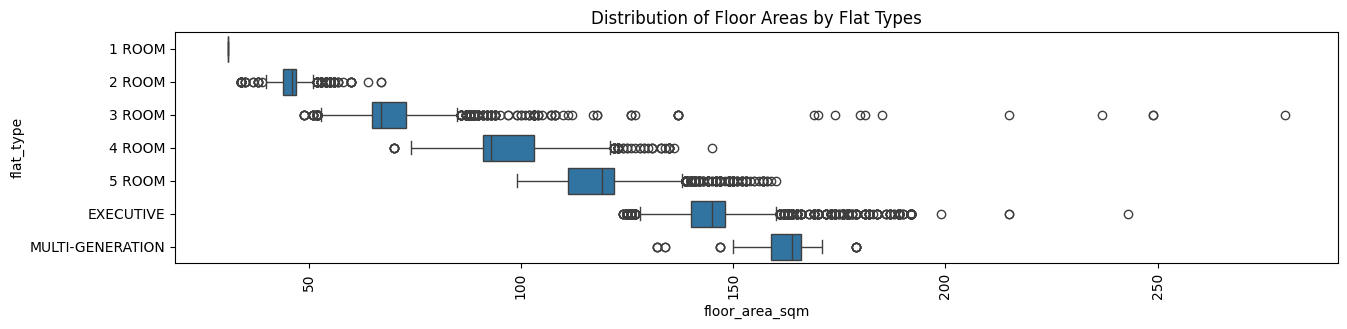

In [4]:
# Display: Boxplot of Floor Area by Flat Type
plt.figure(figsize=(15,3))
sns.boxplot(data=df_train, x="floor_area_sqm", y="flat_type", order=["1 ROOM", "2 ROOM", "3 ROOM", "4 ROOM", "5 ROOM", "EXECUTIVE", "MULTI-GENERATION"])
plt.title("Distribution of Floor Areas by Flat Types")
plt.xticks(rotation=90)

* "Distribution of Floor Area by Flat Type" boxplots reveal significant floor area overlaps between a wide range of adjacent "flat types" (e.g., "3-4 ROOM", "4-5 ROOM" ...)
* "Flat Type" is thus an *unsuitable proxy for floor area*

<b> (b-2) Assess : Relationship between "Floor Area" and "Resale Price"</b>

Correlation:
                 floor_area_sqm  resale_price
floor_area_sqm         1.00000       0.65412
resale_price           0.65412       1.00000


[Text(0.5, 0, 'Floor Area (Quintiles)'), Text(0, 0.5, 'Resale Price')]

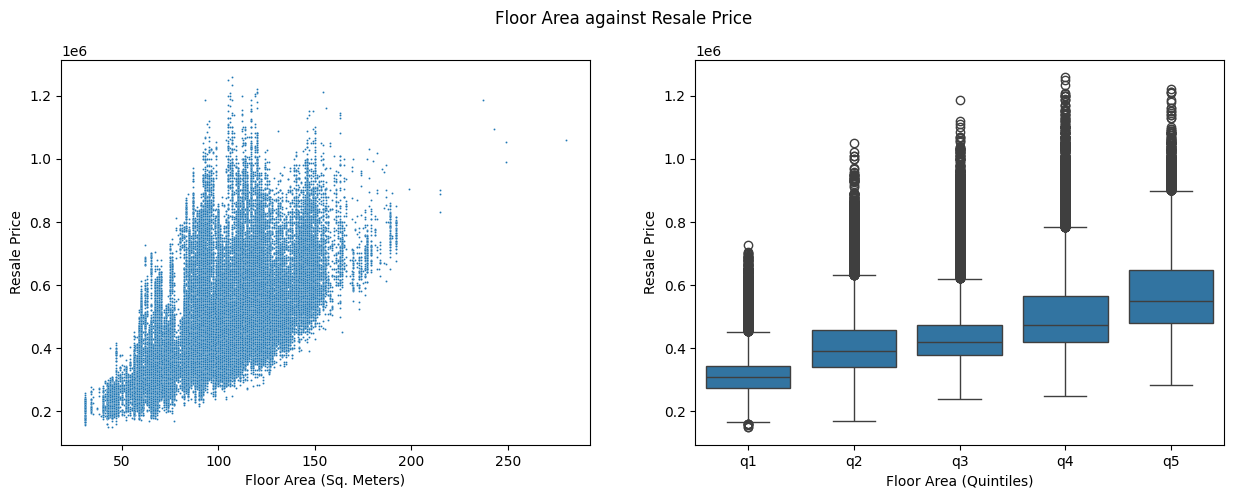

In [5]:
# 1. Correlation Coefficient: "Floor Area" & "Resale Price"
print("Correlation:\n", df_train[["floor_area_sqm","resale_price"]].corr())

# 2. Data Visualisation: Scatter & Boxplots
fig, axes = plt.subplots(1, 2, figsize=(15,5), sharey=False)
fig.suptitle("Floor Area against Resale Price")

sns.scatterplot(ax=axes[0], data=df_train, x="floor_area_sqm", y="resale_price", s=2.0).set(xlabel="Floor Area (Sq. Meters)", ylabel="Resale Price")

df_train["floor_area_sqm_q"] = conti_to_quintile(df_train["floor_area_sqm"])
sns.boxplot(ax=axes[1], data=df_train, x="floor_area_sqm_q", y="resale_price", order=["q1", "q2", "q3", "q4", "q5"]).set(xlabel="Floor Area (Quintiles)", ylabel="Resale Price")

<span style="color: lightblue">

* Observations: 
    * Positive correlation (0.654)
    * Wide variation in prices by floor area - suggesting presence of other factors influencing resale prices
    * Possible non-linear (increasing convex) relationship - given scatterplot of floor area against resale price

<b> (c) Data Cleaning : Floor Area (Square Meters) </b>

<b> 1. Check for Missing Values </b>

In [6]:
# Check: Missing Values
print("No. of missing values:", df_train["floor_area_sqm"].isnull().sum())

No. of missing values: 0


<b> 2. Examine "Floor Area" by "Flat Type-Model" to Assess If there Might be Outliers </b>

"Flat Type-Model" examined as we expect greater convergence in floor areas within granular HDB apartment type categories (e.g., 4 Room Model A, 4 Room Model A2)

(2-1) Examine Distribution of "Floor Area" by "Flat Type-Model"

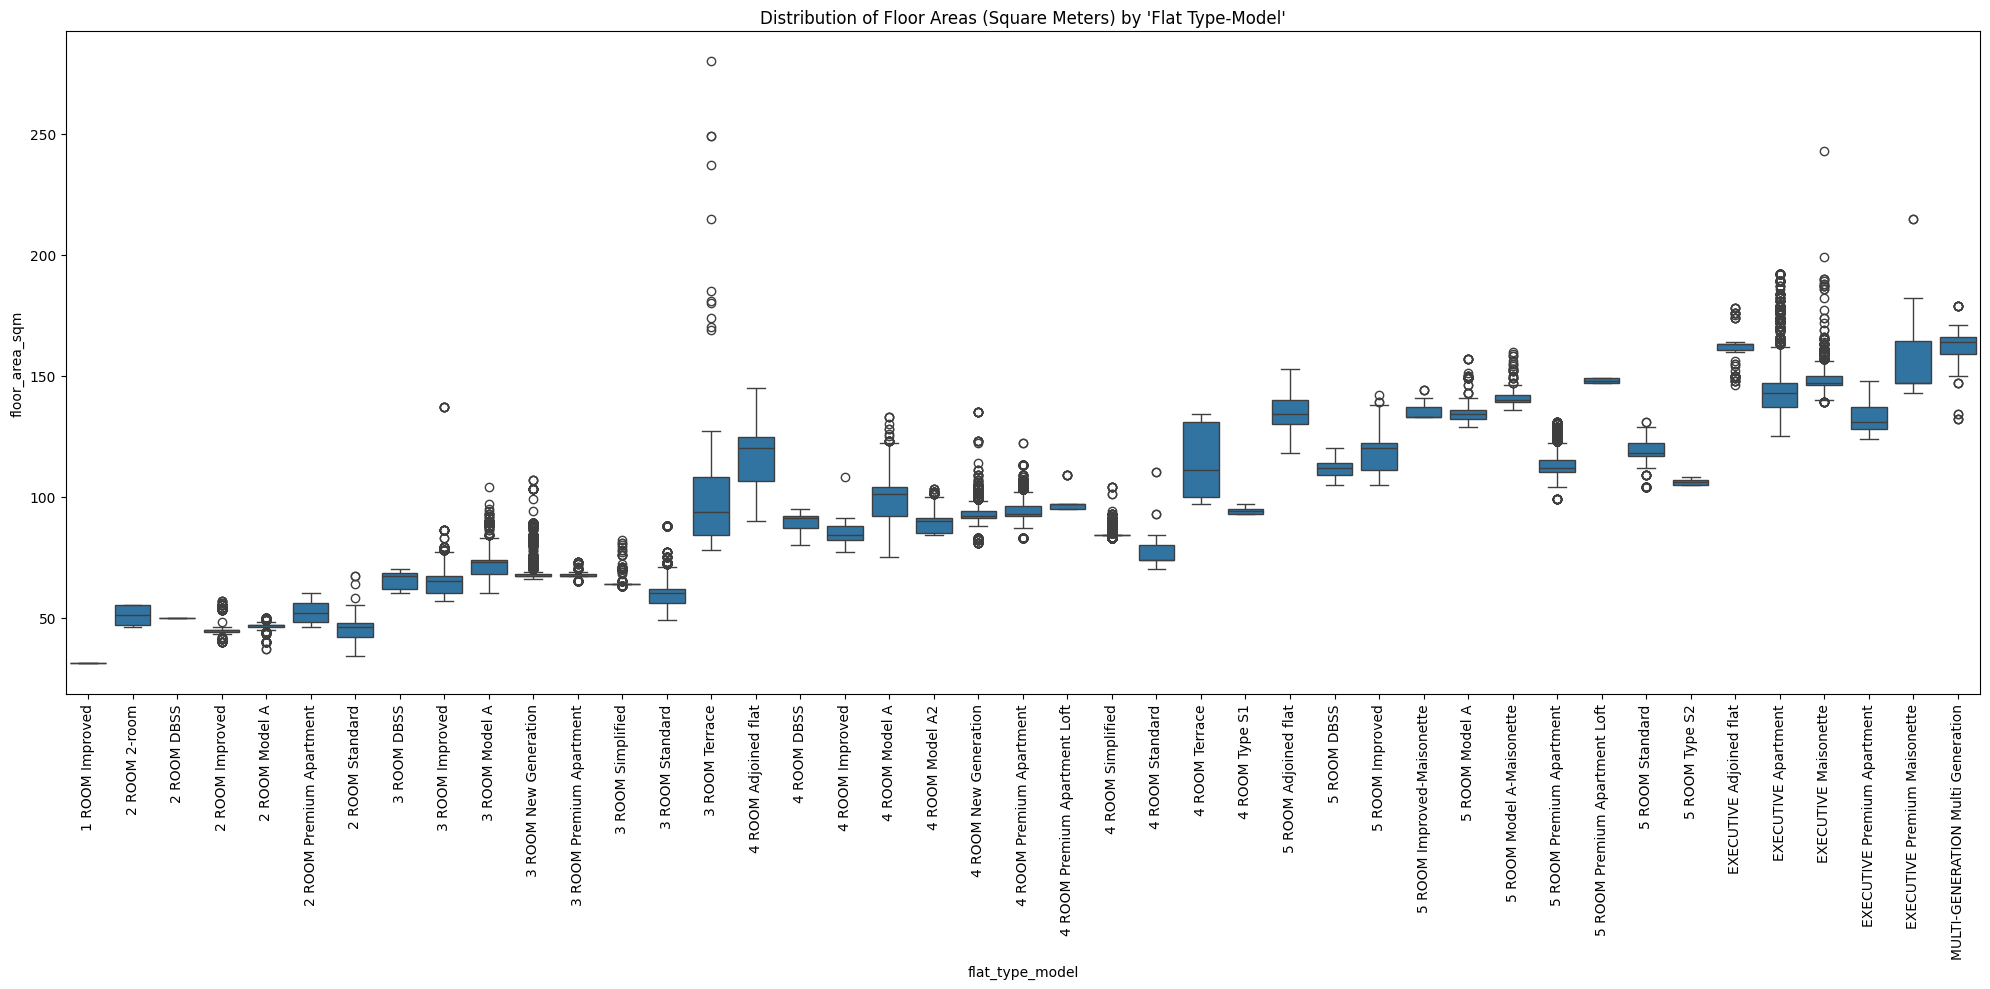

In [7]:
# Add: "Flat Type" + "Flat Model" Variable to Obtain Granular List of Flat Types
df_train["flat_type_model"] = df_train["flat_type"] + " " + df_train["flat_model"]
flat_type_model_list = [type for type in df_train["flat_type_model"].unique()]
flat_type_model_list.sort()

# Display: Distribution of Floor Areas by 'Flat Type-Model'
plt.figure(figsize=(20,10))
sns.boxplot(data=df_train, y="floor_area_sqm", x="flat_type_model", order=flat_type_model_list)
plt.title("Distribution of Floor Areas (Square Meters) by 'Flat Type-Model'")
plt.xticks(rotation=90)
plt.tight_layout()

* Boxplots reveal presence of multiple "outlier" floor areas that fall beyond the "1.5 x Upper (Lower) Quartile" range within each "Flat Type-Model" category
* In addition, these "outliers" tend to cluster  (e.g., 3 Room New Generation, 4 Room New Generation)
* In the absence of additional contextual knowledge, it is difficult to ascertain the cause of these "outliers" and their tendency to cluster 
    * Potential causes include: measurement error, or design/floor area changes within a "flat type-model" category over time
    * Contextual information is thus required, to discern if the "floor area" data should be cleaned (i.e., treated for "outliers")

(2-2) Check Reasonableness of Distributions: Against Contextual Data - "3 Room" , "4 Room" Models' Floor Areas

In [8]:
# Display: Range of Floor Areas - "3-Room" , "4-Room Flat Models

print("== Dataset: Floor Areas - '3-Room', '4-Room' Flat Models' ==", "\n")

for flat_model in ["3 ROOM Improved", "3 ROOM Model A", "3 ROOM New Generation", "3 ROOM Premium Apartment", "3 ROOM Simplified", "3 ROOM Standard", "3 ROOM Terrace",
                   "4 ROOM Improved", "4 ROOM New Generation", "4 ROOM Simplified", "4 ROOM Standard"]:

    # Generate: Min, Max, Median
    floor_area_sqm_min    = df_train.loc[(df_train["flat_type_model"]==flat_model), ["floor_area_sqm"]].min()[0]
    floor_area_sqm_max    = df_train.loc[(df_train["flat_type_model"]==flat_model), ["floor_area_sqm"]].max()[0]
    floor_area_sqm_median = df_train.loc[(df_train["flat_type_model"]==flat_model), ["floor_area_sqm"]].median()[0]

    # Generate: Outlier Detection Thresholds 
    q1 = df_train.loc[(df_train["flat_type_model"]==flat_model), ["floor_area_sqm"]].quantile(0.25)[0]
    q3 = df_train.loc[(df_train["flat_type_model"]==flat_model), ["floor_area_sqm"]].quantile(0.75)[0]    
    iqr = q3 - q1

    threshold = 1.0
    threshold_lower_bound = round(q1 - (threshold)*(iqr), 0)
    threshold_upper_bound = round(q3 + (threshold)*(iqr), 0)

    # Display Stats
    print(f"{flat_model}: (min-max) {floor_area_sqm_min} - {floor_area_sqm_max} (median) {floor_area_sqm_median} (outlier detection thresholds) {threshold_lower_bound} - {threshold_upper_bound}")
    

== Dataset: Floor Areas - '3-Room', '4-Room' Flat Models' == 

3 ROOM Improved: (min-max) 57.0 - 137.0 (median) 65.0 (outlier detection thresholds) 53.0 - 74.0


3 ROOM Model A: (min-max) 60.0 - 104.0 (median) 73.0 (outlier detection thresholds) 62.0 - 80.0
3 ROOM New Generation: (min-max) 66.0 - 107.0 (median) 67.0 (outlier detection thresholds) 66.0 - 69.0
3 ROOM Premium Apartment: (min-max) 65.0 - 73.0 (median) 67.0 (outlier detection thresholds) 66.0 - 69.0
3 ROOM Simplified: (min-max) 63.0 - 82.0 (median) 64.0 (outlier detection thresholds) 64.0 - 64.0
3 ROOM Standard: (min-max) 49.0 - 88.0 (median) 60.0 (outlier detection thresholds) 50.0 - 68.0
3 ROOM Terrace: (min-max) 78.0 - 280.0 (median) 93.5 (outlier detection thresholds) 60.0 - 132.0
4 ROOM Improved: (min-max) 77.0 - 108.0 (median) 84.0 (outlier detection thresholds) 76.0 - 94.0
4 ROOM New Generation: (min-max) 81.0 - 135.0 (median) 92.0 (outlier detection thresholds) 88.0 - 97.0
4 ROOM Simplified: (min-max) 83.0 - 104.0 (median) 84.0 (outlier detection thresholds) 84.0 - 84.0
4 ROOM Standard: (min-max) 70.0 - 110.0 (median) 74.0 (outlier detection thresholds) 68.0 - 86.0


|Flat Type-Model                |Period Built (Contextual Data)   |Floor Area (Contextual Data)   |Floor Area (Dataset: Raw)  |Floor Area (Dataset: "Reasonable Bound")               | 
|-------------------------------|---------------------------------|-------------------------------|---------------------------|-------------------------------------------------------|
|3-Room Improved                |1966 – 1986                      |60 – 76 sqm                    |57 - 137 sqm               |53 - 74 sqm                                            |
|3-Room Model A                 |2002 – present                   |60 – 70 sqm                    |60 - 104 sqm               |62 - 80 sqm                                            |
|3-Room New Generation          |1976 – 1989                      |67 – 88 sqm                    |66 - 107 sqm               |66 - 69 sqm                                            |
|3-Room Premium Apartment       |2016                             |65 sqm                         |65 - 73  sqm               |66 - 69 sqm                                            |
|3-Room Simplified              |1984 – 198                       |65 sqm                         |63 - 82  sqm               |64 sqm                                                 |
|3-Room Standard                |1960 – 1973                      |53 – 71 sqm                    |49 - 88  sqm               |50 - 68 sqm                                            |
|3-room Terrace Houses          |1968 – 1972                      |90 – 155 sqm                   |78 - 280 sqm               |60 - 132 sqm                                           |
|4-room Improved                |1966 – 1980                      |82 – 84 sqm                    |77 - 108 sqm               |76 - 94 sqm                                            |
|4-room New Generation          |1976 – 1989                      |92 sqm                         |81 - 135 sqm               |88 - 97 sqm                                            |
|4-room Simplified              |1984 – 1989                      |84 sqm                         |83 - 104 sqm               |84 sqm                                                 |
|4-room Standard                |1960s – 1970s                    |70 - 75 sqm                    |70 - 110 sqm               |68 - 86 sqm                                            |

* Contextual data published by a well-regarded personal finance periodical - but may nonetheless contain errors as (a) sources are not cited, (b) possible variation in floor areas over time for the same "flat type - model" 
    * Dollars & Sense (2024). 3STD, 3I, 3S, 3NG, 3A: Guide To Understanding The Different Variations Of 3-Room HDB Flats - [link](https://dollarsandsense.sg/better-off-renting-wait-bto-flat-buy-resale-hdb-immediately/)
    * Dollars & Sense (2023). HDB4A, 4S, 4I: Why Are There So Many Types Of HDB 4-Room Flats In Singapore - [link](https://dollarsandsense.sg/hdb-4-room-flats-singapore/)
* Comparison of "contextual data" and "dataset: raw" columns suggest presence of clear outliers
* Applying a "resonable bound" of [q1 - (1 x IQR) , q3 - (1 x IQR) ] to exclude outliers appears appropriate, as bound's fit with contextual data is relatively close
    * In addition, in the absence of an official source of ground truth - this approach appears the most appropriate

(2-3) Cleaning Procedure(s) to Adopt

<span style="color: yellowgreen">

* Reasonable Bound: [ q1 - (1 x IQR) , q3 - (1 x IQR) ]
* Deem datapoints beyond the "reasonable bound" to be outliers - to exclude outliers from analysis

<b> (d) Feature(s) to Engineer </b>

<span style="color: yellowgreen">

* Add squared term: Floor Area (Square Meters) ^ 2
    * test for non-linearity of the "floor area - resale price" relationship


---
<b> Hypothesis (2) : Apartment's Floor Level is Positively Related with Resale Price </b>

<br>
<b>(a) Background</b>

* An apartment's floor level is expected to be positively related with resale price - however, there are several data columns related to an apartment's "floor level", and these will firstly be examined to select an appropriate one for use
* The "floor level - resale price" relationship will then be examined for its direction and possible non-linearity

<br>
<b>(b-1) Assess : Appropriate Floor Level Data Column to Use</b>

In [9]:
# Examine: Floor Level Data Columns
df_train[["storey_range","mid_storey", "lower", "upper", "mid"]].head(5)

,storey_range,mid_storey,lower,upper,mid
0,10 TO 12,11,10,12,11
1,07 TO 09,8,7,9,8
2,13 TO 15,14,13,15,14
3,01 TO 05,3,1,5,3
4,01 TO 03,2,1,3,2


* As data on the exact "floor level" of an apartment is not available, "mid" (i.e., middle of the "story range") data will be used as a proxy for each apartment's floor level

<br> 
<b>(b-2) Assess : Relationship between "Floor Level" and "Resale Price"</b>

Floor Level (min): 2
Floor Level (max): 50 

Correlation:
                    mid  resale_price
mid           1.000000      0.353213
resale_price  0.353213      1.000000


[Text(0.5, 0, 'Floor Level'), Text(0, 0.5, 'Resale Price')]

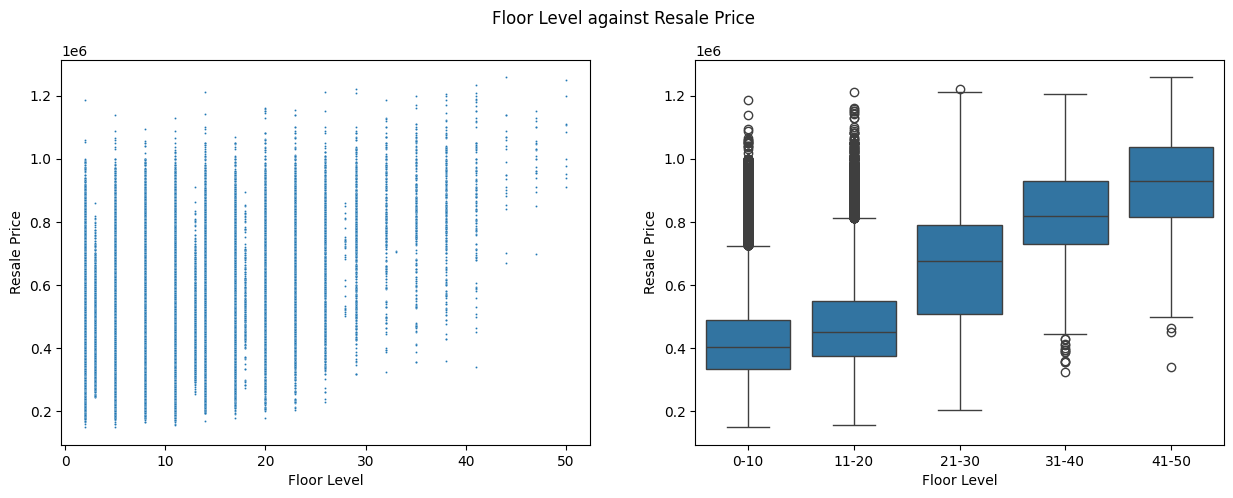

In [10]:
# 1. Display: "Floor Level" Min-Max Range
print("Floor Level (min):", df_train["mid"].min())
print("Floor Level (max):", df_train["mid"].max(), "\n")

# 2. Correlation Coefficient: "Floor Level" & "Resale Price"
print("Correlation:\n", df_train[["mid","resale_price"]].corr())

# 3. Data Visualisation: Scatter & Boxplots
fig, axes = plt.subplots(1, 2, figsize=(15,5), sharey=False)
fig.suptitle("Floor Level against Resale Price")

sns.scatterplot(ax=axes[0], data=df_train, x="mid", y="resale_price", s=2.0).set(xlabel="Floor Level", ylabel="Resale Price")

df_train["mid_cat"] = pd.cut(x=df_train["mid"], bins=[0,10,20,30,40,50], labels=["0-10", "11-20", "21-30", "31-40", "41-50"]) # 
sns.boxplot(ax=axes[1], data=df_train, x="mid_cat", y="resale_price", order=["0-10", "11-20", "21-30", "31-40", "41-50"]).set(xlabel="Floor Level", ylabel="Resale Price")

<span style="color: lightblue">

* Observations: 
    * Positive correlation (0.353)
    * Wide variation in prices by floor level - suggesting presence of other factors influencing resale prices
    * Possible non-linear relationship - with greatest jump in median prices from the '11-20' to '21-30' floor brackets

<b> (c) Data Cleaning : Floor Level </b>

<b> 1. Check for Missing Values </b>

In [11]:
# Check: Missing Values
print("No. of missing values:", df_train["mid"].isnull().sum())

No. of missing values: 0


<b> 2. Examine Distribution of "Floor Level" for Potential Outliers </b>

(2-1) Examine Distribution of "Floor Area" by "Flat Type-Model"

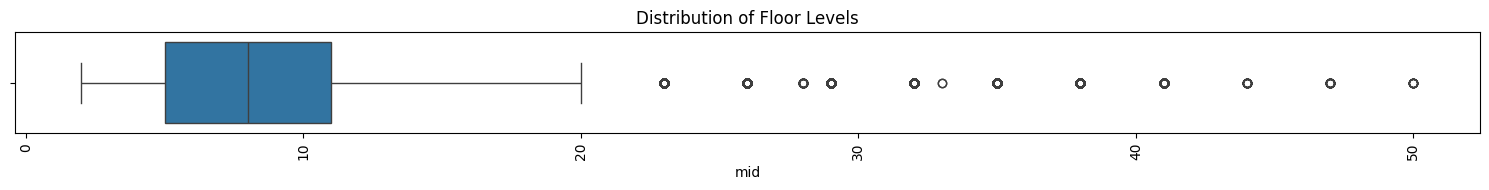

In [12]:
# Display: Distribution of Floor Levels
plt.figure(figsize=(15, 2))
sns.boxplot(data=df_train, x="mid")
plt.title("Distribution of Floor Levels")
plt.xticks(rotation=90)
plt.tight_layout()

* There are floor level "outliers" beyond the "3Q + (1.5 x IQR)" bound, with a maximum floor level of 50
* However, these are unlikely to reflect measurement errors, as there are HDB flats that are 50 stories high
    * Property Guru. (2021). 189 Tallest HDB Blocks in Singapore With Over 30 Storeys for Unblocked Panoramic Views - [link](https://www.propertyguru.com.sg/property-guides/tallest-hdb-flats-50281)

(2-2) Cleaning Procedure(s) to Adopt

<span style="color: yellowgreen">

* Nil - "Floor level" data will thus be left "as-is", as exceptional floor levels may explain exceptional resale prices

<b> (d) Feature(s) to Engineer </b>

<span style="color: yellowgreen">

* Add squared term: Floor Level ^ 2
    * test for non-linearity of the "floor level - resale price" relationship


---
<b> Hypothesis (3) : Exceptional Apartment Characteristics are Associated with Higher Resale Prices </b>

<br><b>(a) Background</b>

HDB apartments come in a wide range of flat type-models. We thus hypothesize that some of these flat type-models may be associated with significantly higher prices. We thus wish to: 
* Examine resale prices by flat type-model to identify flat type-models that exhibit significantly higher prices
* Understand exceptional features within these flat type-models that might explain their higher prices

<br><b>(b) Assess : Resale Prices by Flat Type-Model</b>

In [13]:
# Add: "Flat Type" + "Flat Model" Variable
df_train["flat_type_model"] = df_train["flat_type"] + "\n" + df_train["flat_model"]
flat_type_model_list = [type for type in df_train["flat_type_model"].unique()]
flat_type_model_list.sort()

# Add: Sub-Group Lists
list_display_1RM_2RM = [type for type in flat_type_model_list if "1 ROOM" in type or "2 ROOM" in type]
list_display_3RM = [type for type in flat_type_model_list if "3 ROOM" in type]
list_display_4RM = [type for type in flat_type_model_list if "4 ROOM" in type]
list_display_5RM = [type for type in flat_type_model_list if "5 ROOM" in type]
list_display_OTH = [type for type in flat_type_model_list if "EXECUTIVE" in type or "MULTI-GENERATION" in type]

C:\Users\joell\AppData\Local\Temp\ipykernel_1896\3814189014.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[1], data=df_train, y="resale_price", x="flat_type_model", order=list_display_3RM, palette=pal).set(title="Distribution of Resale Prices: 3-Room Models", xlabel="", ylabel="Resale Price")


C:\Users\joell\AppData\Local\Temp\ipykernel_1896\3814189014.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[2], data=df_train, y="resale_price", x="flat_type_model", order=list_display_4RM, palette=pal).set(title="Distribution of Resale Prices: 4-Room Models", xlabel="", ylabel="Resale Price")
C:\Users\joell\AppData\Local\Temp\ipykernel_1896\3814189014.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[3], data=df_train, y="resale_price", x="flat_type_model", order=list_display_5RM, palette=pal).set(title="Distribution of Resale Prices: 5-Room Models", xlabel="", ylabel="Resale Price")
C:\Users\joell\AppData\Local\Temp\ipykernel_1896\3814189014.py:27: FutureWarning: 

[Text(0.5, 1.0, 'Distribution of Resale Prices: Executive & Multi-Generation Models'),
 Text(0.5, 0, ''),
 Text(0, 0.5, 'Resale Price')]

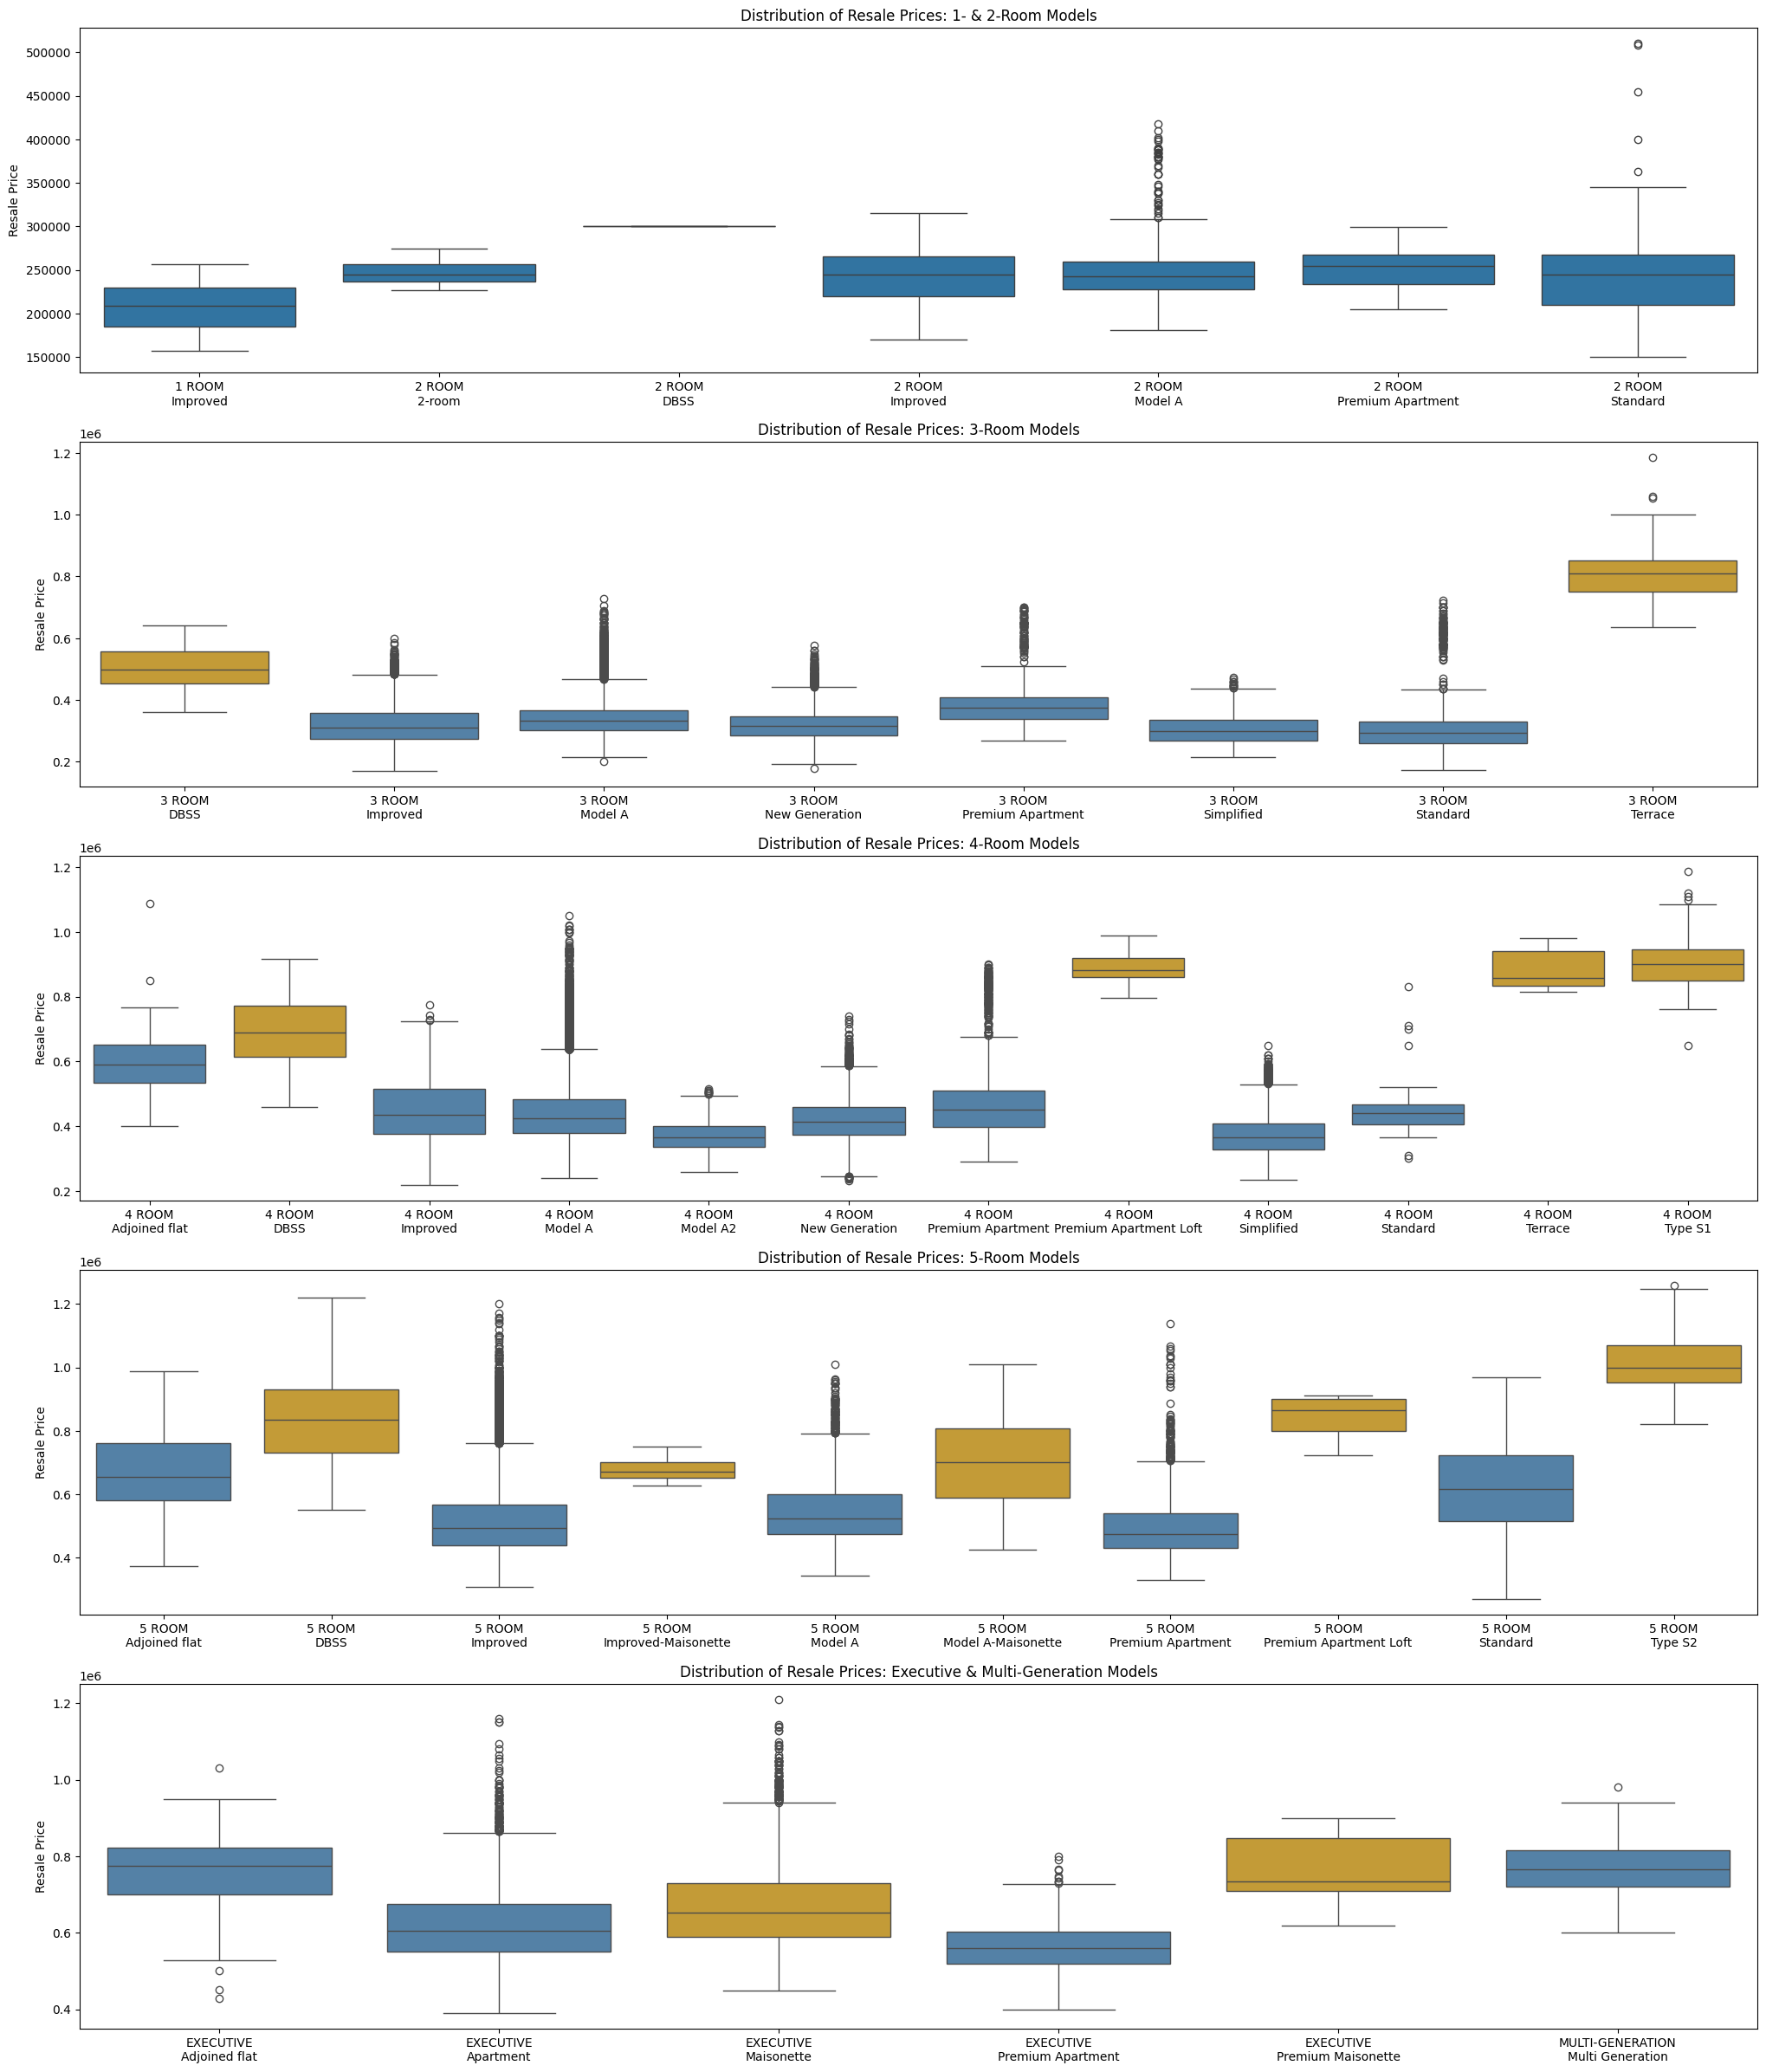

In [14]:
# 3. Data Visualisation: Scatter & Boxplots
fig, axes = plt.subplots(5, 1, figsize=(25,30), sharey=False)

# Distribution of Resale Prices: 1- & 2-Room Models
sns.boxplot(ax=axes[0], data=df_train, y="resale_price", x="flat_type_model", order=list_display_1RM_2RM).set(title="Distribution of Resale Prices: 1- & 2-Room Models", xlabel="", ylabel="Resale Price")

# Distribution of Resale Prices: 3-Room Models
pal = {flat_type_model:"goldenrod" if (flat_type_model=="3 ROOM\nDBSS" or flat_type_model=="3 ROOM\nTerrace") else "steelblue" for flat_type_model in list_display_3RM}
sns.boxplot(ax=axes[1], data=df_train, y="resale_price", x="flat_type_model", order=list_display_3RM, palette=pal).set(title="Distribution of Resale Prices: 3-Room Models", xlabel="", ylabel="Resale Price")

# Distribution of Resale Prices: 4-Room Models
pal = {flat_type_model:"goldenrod" 
        if (flat_type_model=="4 ROOM\nDBSS" or flat_type_model=="4 ROOM\nPremium Apartment Loft" or flat_type_model=="4 ROOM\nTerrace" or flat_type_model=="4 ROOM\nType S1") 
        else "steelblue" for flat_type_model in list_display_4RM}
sns.boxplot(ax=axes[2], data=df_train, y="resale_price", x="flat_type_model", order=list_display_4RM, palette=pal).set(title="Distribution of Resale Prices: 4-Room Models", xlabel="", ylabel="Resale Price")

# Distribution of Resale Prices: 5-Room Models
pal = {flat_type_model:"goldenrod" 
        if (flat_type_model=="5 ROOM\nDBSS" or flat_type_model=="5 ROOM\nImproved-Maisonette" or flat_type_model=="5 ROOM\nModel A-Maisonette" or flat_type_model=="5 ROOM\nPremium Apartment Loft" or flat_type_model=="5 ROOM\nType S2") 
        else "steelblue" for flat_type_model in list_display_5RM}
sns.boxplot(ax=axes[3], data=df_train, y="resale_price", x="flat_type_model", order=list_display_5RM, palette=pal).set(title="Distribution of Resale Prices: 5-Room Models", xlabel="", ylabel="Resale Price")

# Distribution of Resale Prices: Others (Executive & Multi-Generation Models)
pal = {flat_type_model:"goldenrod" 
        if (flat_type_model=="EXECUTIVE\nMaisonette" or flat_type_model=="EXECUTIVE\nPremium Maisonette") 
        else "steelblue" for flat_type_model in list_display_OTH}
sns.boxplot(ax=axes[4], data=df_train, y="resale_price", x="flat_type_model", order=list_display_OTH, palette=pal).set(title="Distribution of Resale Prices: Executive & Multi-Generation Models", xlabel="", ylabel="Resale Price")


<span style="color: lightblue">

* Observations: 

    * There are "models" that have higher resale prices compared to their "flat type" (ref: "dark yellow" boxplots), and these relate to the following "models":
        * "DBSS" models : apartments built by private developers, and were intended to have premium interiors - [1] [link](https://www.propertyguru.com.sg/property-guides/dbss-singapore-17893)
        * "Terrace" models : akin to landed properties - [2] [link](https://www.propertyguru.com.sg/property-guides/cheap-hdb-terrace-house-under-850k-35237)
        * "Mansionette/Loft" : models: akin to 2-storey landed properties in the sky - [3] [link](https://www.99.co/singapore/insider/difference-hdb-loft-executive-maisonettes/)
        * "Duxton S-types" : pinnacle@duxton flats known for their city-centre location and landmark architectural features - [4] [link](https://www.nlb.gov.sg/main/article-detail?cmsuuid=156f0c70-8446-4386-ab34-e67de71a79ca)

<b> (c) Data Cleaning : Flat Model, Flat Type </b>

1. Check for Missing Values

In [15]:
# Check: Missing Values
print("No. of missing values (Flat Model):", df_train["flat_model"].isnull().sum())
print("No. of missing values (Flat Type):", df_train["flat_type"].isnull().sum())

No. of missing values (Flat Model): 0
No. of missing values (Flat Type): 0


<b> (d) Feature(s) to Engineer </b>

<span style="color: yellowgreen">

* "DBSS", "Terrace", "Mansionette/Loft", "Duxton S-Type" Dummies


---
<br>
<b> Hypothesis (4) : Apartment's Remaining Lease Period is Positively Associated with Resale Price </b>

<br> <b> (a) Background </b>

* HDB apartments are first sold by the government on a 99 year lease
* An apartment's remaining lease period thus declines at the point of resale, when apartments are bought/sold on the open-market between private individuals
* Given the leasehold nature of HDB apartments, it is hypothesized that an apartment's resale price tends to be higher with a longer remaining lease
* In addition, we expect rapidly diminishing resale value "close" to the lease expiry

<br> <b> (b) Assess : Relationship between "Remaining Lease Period" and "Resale Price" </b>

Remaining Lease Period (Years) (min): 45
Remaining Lease Period (Years) (max): 98 

Correlation:
                  remaining_lease  resale_price
remaining_lease         1.000000      0.362285
resale_price            0.362285      1.000000


[Text(0.5, 0, 'Remaining Lease Period (Years)'), Text(0, 0.5, 'Resale Price')]

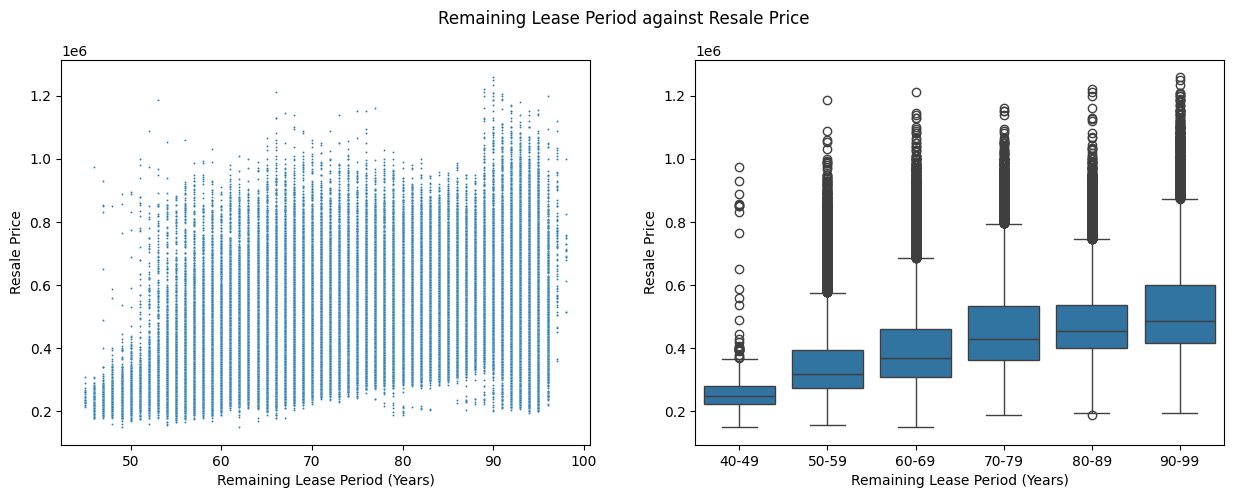

In [16]:
# 1. Add: Remaining Lease Period
df_train["remaining_lease"] = 99 - (df_train["tranc_year"] - df_train["lease_commence_date"])

# 2. Display: "Remaining Lease Period" Min-Max Range
print("Remaining Lease Period (Years) (min):", df_train["remaining_lease"].min())
print("Remaining Lease Period (Years) (max):", df_train["remaining_lease"].max(), "\n")

# 3. Correlation Coefficient: "Remaining Lease Period" & "Resale Price"
print("Correlation:\n", df_train[["remaining_lease","resale_price"]].corr())

# 4. Data Visualisation: Scatter & Boxplots
fig, axes = plt.subplots(1, 2, figsize=(15,5), sharey=False)
fig.suptitle("Remaining Lease Period against Resale Price")

sns.scatterplot(ax=axes[0], data=df_train, x="remaining_lease", y="resale_price", s=2.0).set(xlabel="Remaining Lease Period (Years)", ylabel="Resale Price")

df_train["remaining_lease_cat"] = pd.cut(x=df_train["remaining_lease"], bins=[40,49,59,69,79,89,99], labels=["40-49", "50-59", "60-69", "70-79", "80-89", "90-99"]) 
sns.boxplot(ax=axes[1], data=df_train, x="remaining_lease_cat", y="resale_price", order=["40-49", "50-59", "60-69", "70-79", "80-89", "90-99"]).set(xlabel="Remaining Lease Period (Years)", ylabel="Resale Price")

<span style="color: lightblue">

* Observations: 
    * Positive correlation (0.362), with wide variation in prices by remaining lease years - suggesting presence of other factors influencing resale prices
    * Considering boxplots on the right, the increase in median resale value appears to diminish with longer remaining lease periods
        * Although presence and extent of this trend will need to be examined further by controlling for potential confounders (e.g., floor area, as older flats of the same flat-model type tend to be larger - [link](https://stackedhomes.com/editorial/have-hdb-flats-really-gotten-smaller-over-the-years-heres-a-look-at-the-data/))
        

<b> (c) Data Cleaning : Remaining Lease Period </b>

1. Check for Missing Values

In [17]:
# Check: Missing Values
print("No. of missing values:", df_train["remaining_lease"].isnull().sum())

No. of missing values: 0


<b> (d) Feature(s) to Engineer </b>

<span style="color: yellowgreen">

* Add squared term: Remaining Lease Period ^ 2
    * test for non-linearity of the "Remaining Lease Period" - "Resale Price" relationship


---
<br>
<b> Hypothesis (5) : Apartment's Neighbour Composition is Associated with Resale Price </b>

<b> (a) Background </b>

* HDB apartment blocks contain a range of flat models (e.g., 3-Room, 4-Room flat types) within blocks
* The mix of flat models within blocks is hypothesized to be associated with resale price, as these are indicators of neighbours' profiles
* Specifically, we hypothesize that: presence of rental units is negatively associated with resale price

<br> <b> (b) Assess : Relationship between "Within Block: Presence of Rental Units" and "Resale Price" </b>

If Apartment Block has Rental Units (proportion with): 0.037
If Apartment Block has Rental Units (percentiles): (0.25) 0.0, (0.5) 0.0, (0.75) 0.0 

Apartment Block has Rental Units - Proportion of Rental Units (mean): 0.095
Apartment Block has Rental Units - Proportion of Rental Units (max): 0.963
Apartment Block has Rental Units - Proportion of Rental Units (percentiles): (0.25) 0.006, (0.5) 0.009, (0.75) 0.021, (0.90) 0.457) 

Correlation:
                       block_rental_present  resale_price
block_rental_present              1.000000     -0.178173
resale_price                     -0.178173      1.000000

Median Resale Price - If Apartment Block has Rental Units (1: Yes): 306888.0
Median Resale Price - If Apartment Block has Rental Units (0: No): 425500.0


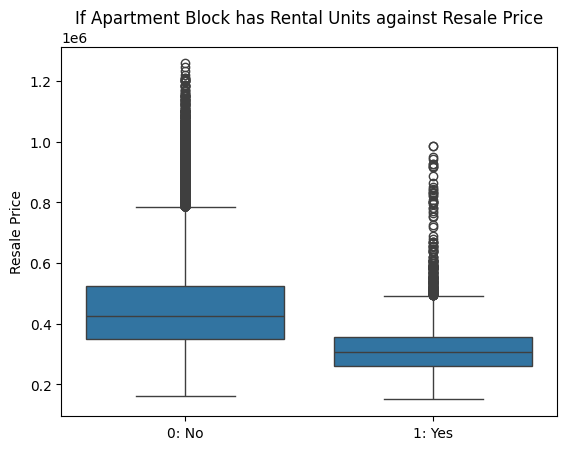

In [18]:
# 1. Add: If Apartment Block has Rental Units
df_train["block_rental_n_units"]    = df_train["1room_rental"] + df_train["2room_rental"] + df_train["3room_rental"] + df_train["other_room_rental"]
df_train["block_rental_proportion"] = df_train["block_rental_n_units"]/df_train["total_dwelling_units"]
df_train["block_rental_present"]    = (df_train["block_rental_n_units"]>0).astype(int)

# 2. Display: "If Apartment Block has Rental Units" Statistics
print(f'If Apartment Block has Rental Units (proportion with): {round(df_train["block_rental_present"].mean(),3)}')
print(f'If Apartment Block has Rental Units (percentiles): (0.25) {round(df_train["block_rental_present"].quantile(0.25),0)}, (0.5) {round(df_train["block_rental_present"].quantile(0.5),0)}, (0.75) {round(df_train["block_rental_present"].quantile(0.75),0)}', '\n')

mean = round(df_train.loc[(df_train["block_rental_proportion"]>0), ["block_rental_proportion"]].mean()[0],3)
max  = round(df_train.loc[(df_train["block_rental_proportion"]>0), ["block_rental_proportion"]].max()[0],3)
p025 = round(df_train.loc[(df_train["block_rental_proportion"]>0), ["block_rental_proportion"]].quantile(0.25)[0],3)
p050 = round(df_train.loc[(df_train["block_rental_proportion"]>0), ["block_rental_proportion"]].quantile(0.50)[0],3)
p075 = round(df_train.loc[(df_train["block_rental_proportion"]>0), ["block_rental_proportion"]].quantile(0.75)[0],3)
p090 = round(df_train.loc[(df_train["block_rental_proportion"]>0), ["block_rental_proportion"]].quantile(0.90)[0],3)

print(f'Apartment Block has Rental Units - Proportion of Rental Units (mean): {mean}')
print(f'Apartment Block has Rental Units - Proportion of Rental Units (max): {max}')
print(f'Apartment Block has Rental Units - Proportion of Rental Units (percentiles): (0.25) {p025}, (0.5) {p050}, (0.75) {p075}, (0.90) {p090})', '\n')

# 3. Correlation Coefficient: "If Apartment Block has Rental Units" & "Resale Price"
print("Correlation:\n", df_train[["block_rental_present","resale_price"]].corr())

# 4. Data Visualisation: Boxplots
plt.title("If Apartment Block has Rental Units against Resale Price")
sns.boxplot(data=df_train, x="block_rental_present", y="resale_price", order=[0,1]).set(xlabel="", ylabel="Resale Price")
plt.xticks([0, 1], ["0: No", "1: Yes"])

# 5. Display: "If Apartment Block has Rental Units" Statistics
print("")
print(f'Median Resale Price - If Apartment Block has Rental Units (1: Yes): {df_train.loc[(df_train["block_rental_present"]==1), ["resale_price"]].median()[0]}')
print(f'Median Resale Price - If Apartment Block has Rental Units (0: No): {df_train.loc[(df_train["block_rental_present"]==0), ["resale_price"]].median()[0]}')


<span style="color: lightblue">

* Observations: 
    * Negative correlation (-0.178), indicating that presence of rental units within a block is associated with lower resale prices  
    * This is also reflected in the lower median resale price of flats located within blocks with rental units ($307,000), compared to those without ($426,000)
    * However, the presence of rental units within a block is likely associated with smaller resale flat floor areas – and such potential confounders will need to be controlled for subsequently to identify potential 'neighbour' effects
    * Additionally, we note that:
        * Only a small proportion (~3%) of resale transactions involved flats within blocks with rental units.
        * Out of which, the proportion of rental units in these blocks were less than 5% in the vast majority of cases 

<b> (c) Data Cleaning</b>

1. Check for Missing Values

In [19]:
for var in ["1room_rental", "2room_rental", "3room_rental", "other_room_rental", "5room_sold", "exec_sold", "multigen_sold", "total_dwelling_units"]:
    print(f"No. of missing values: {df_train[var].isnull().sum()} | var: {var}")

No. of missing values: 0 | var: 1room_rental
No. of missing values: 0 | var: 2room_rental
No. of missing values: 0 | var: 3room_rental
No. of missing values: 0 | var: other_room_rental
No. of missing values: 0 | var: 5room_sold
No. of missing values: 0 | var: exec_sold
No. of missing values: 0 | var: multigen_sold
No. of missing values: 0 | var: total_dwelling_units


<b> (d) Feature(s) to Engineer </b>

<span style="color: yellowgreen">

* If Apartment Block has Rental Units


---
<br>
<b> Hypothesis (6) : Accessibility to Transport Infrastructure is Positively Associated with Resale Price </b>

<br> <b> (a) Background </b>

Proximity to transport nodes offers travelling convenience, and this is thus hypothesised to be positively related with apartments' resale prices.

In this regard, the following measures of proximity to transport nodes, and corresponding hypothesized relationships with resale price are as follows:   
* H-5A: Proximity to the Nearest MRT station is Positively Correlated with Resale Price 
* H-5B: Nearest MRT station being a Train/Bus Interchange is Positively Correlated with Resale Price 
* H-5C: Nearest Bus Stop within Close Proximity (100m) is Positively Correlated with Resale Price

<br> <b> (b-1) [H-6A] Assess : Relationship between "Proximity to the Nearest MRT Station" and "Resale Price" </b>

A categorical measure of proximity to the nearest MRT station will be used to aid with interpreting results:
* (a) 0 - 500m (Within Walking Distance)
    * Public transit planners typically assume that most users arrive and depart from transit stops via walking, and often define a catchment zone between 400-800m from a stop
    * Durand et al. (2017). The Association of Trip Distance With Walking To Reach Public Transit: Data from the California Household Travel Survey. Journal of Transport & Health - [Link](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4941821/)
    * For our purposes, we'll use a distance of 500m as a "within walking distance" cutoff
* (b) 500 - 1000m
* (c) Beyond 1000m 


Distance to Nearest MRT Station (m) (min): 22.0
Distance to Nearest MRT Station (m) (max): 3545.0
Distance to Nearest MRT Station (m) (percentiles): (0.25) 458.0, (0.5) 683.0, (0.75) 976.0 

Correlation:
                       mrt_nearest_distance  resale_price
mrt_nearest_distance              1.000000     -0.128222
resale_price                     -0.128222      1.000000

Median Resale Price [0,500] - Within Walking Distance: 457000.0
Median Resale Price (500,1000]: 410000.0
Median Resale Price >1000: 415000.0


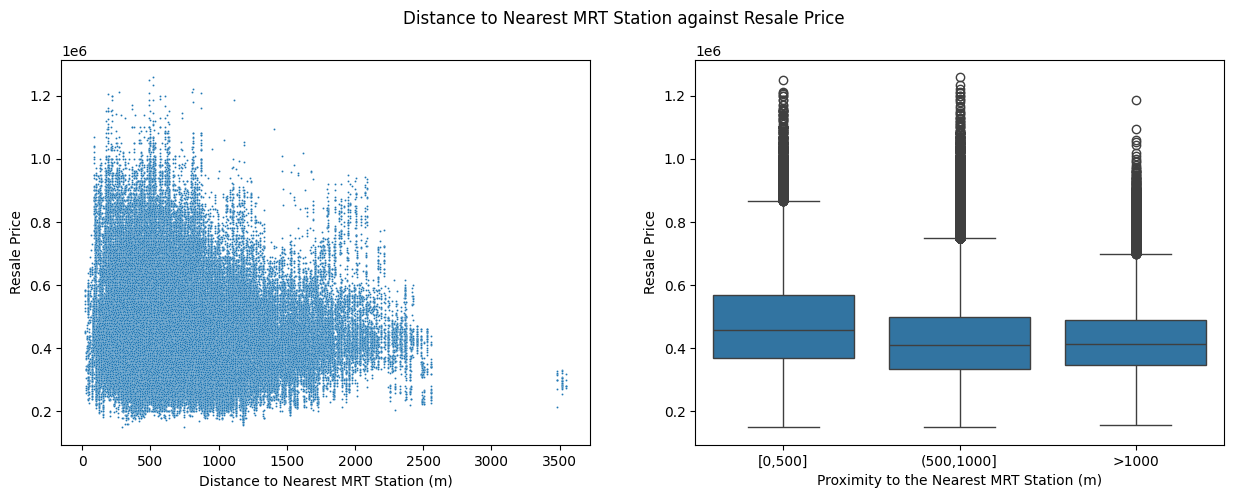

In [20]:
# 1. Display: "Distance to Nearest MRT Station" Statistics
print("Distance to Nearest MRT Station (m) (min):", round(df_train["mrt_nearest_distance"].min(),0))
print("Distance to Nearest MRT Station (m) (max):", round(df_train["mrt_nearest_distance"].max(),0))
print(f'Distance to Nearest MRT Station (m) (percentiles): (0.25) {round(df_train["mrt_nearest_distance"].quantile(0.25),0)}, (0.5) {round(df_train["mrt_nearest_distance"].quantile(0.5),0)}, (0.75) {round(df_train["mrt_nearest_distance"].quantile(0.75),0)}', '\n')

# 2. Correlation Coefficient: "Distance to Nearest MRT Station" & "Resale Price"
print("Correlation:\n", df_train[["mrt_nearest_distance","resale_price"]].corr())

# 3. Data Visualisation: Scatter & Boxplots
fig, axes = plt.subplots(1, 2, figsize=(15,5), sharey=False)
fig.suptitle("Distance to Nearest MRT Station against Resale Price")

sns.scatterplot(ax=axes[0], data=df_train, x="mrt_nearest_distance", y="resale_price", s=2.0).set(xlabel="Distance to Nearest MRT Station (m)", ylabel="Resale Price")

df_train["mrt_nearest_distance_cat"] = pd.cut(x=df_train["mrt_nearest_distance"], bins=[0,500,1000,3600], labels=["[0,500]", "(500,1000]", ">1000"])
sns.boxplot(ax=axes[1], data=df_train, x="mrt_nearest_distance_cat", y="resale_price", order=["[0,500]", "(500,1000]", ">1000"]).set(xlabel="Proximity to the Nearest MRT Station (m)", ylabel="Resale Price")

# 4. Display: "Proximity to the Nearest MRT Station" Statistics
print("")
print(f'Median Resale Price [0,500] - Within Walking Distance: {df_train.loc[(df_train["mrt_nearest_distance_cat"]=="[0,500]"), ["resale_price"]].median()[0]}')
print(f'Median Resale Price (500,1000]: {df_train.loc[(df_train["mrt_nearest_distance_cat"]=="(500,1000]"), ["resale_price"]].median()[0]}')
print(f'Median Resale Price >1000: {df_train.loc[(df_train["mrt_nearest_distance_cat"]==">1000"), ["resale_price"]].median()[0]}')


<span style="color: lightblue">

* Observations:
    * Negative correlation (-0.128), indicating that closer proximity to an MRT station is associated with higher resale prices  
    * This is also reflected in the lower median resale price of flats beyond walking distance (>500m)
    * Descriptive statistics above suggest that the price premium for being close to an MRT station only is confined to a 500m radius around the station, although this will need to be investigated further 
    * Wide variation in prices by distance to the nearest MRT station - suggesting presence of other factors influencing resale prices

<br> <b> (b-2) [H-6B] Assess : Relationship between "Nearest MRT station being a Train / Bus Interchange" and "Resale Price" </b>

In [21]:
# Display: Relationship between Nearest MRT Station being a Train / Bus Interchange & Resale Price

# 1. Define Mutually Exclusive Categorical Features
df_train["nearest_mrt_interchange_train_bus"]  = ((df_train["mrt_interchange"]==1) & (df_train["bus_interchange"]==1)).astype(int)
df_train["nearest_mrt_interchange_train_only"] = ((df_train["mrt_interchange"]==1) & (df_train["bus_interchange"]==0)).astype(int)
df_train["nearest_mrt_interchange_bus_only"]   = ((df_train["mrt_interchange"]==0) & (df_train["bus_interchange"]==1)).astype(int)
df_train["nearest_mrt_interchange_nil"]        = ((df_train["mrt_interchange"]==0) & (df_train["bus_interchange"]==0)).astype(int)

# 2. Display Correlations
print("\nCorrelation: nearest_mrt_interchange_train_bus\n", round(df_train[["nearest_mrt_interchange_train_bus","resale_price"]].corr()["resale_price"][0],5))
print("\nCorrelation: nearest_mrt_interchange_train_only\n", round(df_train[["nearest_mrt_interchange_train_only","resale_price"]].corr()["resale_price"][0],5))
print("\nCorrelation: nearest_mrt_interchange_bus_only\n", round(df_train[["nearest_mrt_interchange_bus_only","resale_price"]].corr()["resale_price"][0],5))
print("\nCorrelation: nearest_mrt_interchange_nil\n", round(df_train[["nearest_mrt_interchange_nil","resale_price"]].corr()["resale_price"][0],5))


Correlation: nearest_mrt_interchange_train_bus
 0.05876

Correlation: nearest_mrt_interchange_train_only
 0.02552

Correlation: nearest_mrt_interchange_bus_only
 -0.05078

Correlation: nearest_mrt_interchange_nil
 -0.01157


<span style="color: lightblue">

* Observations: 
    * Flat's resale price is positively associated with the nearest MRT station being a train hub (0.026), with the association being stronger if the latter is also a bus hub (0.059)
    * However, negative associations are observed on the nearest mrt station being a bus hub only, and being neither a train nor bus hub
    * The above associations are nonetheless fairly weak – with subsequent regression analysis being able to better isolate these features’ associations with resale price 

<br> <b> (b-3) [H-6C] Assess : Relationship between "Close Proximity to Nearest Bus Stop (Meters)" and "Resale Price" </b>

Definition :: Within Close Proximity
* Bus stop close proximity cutoff: 150m
* Decided upon based on distance at the 75th percentile (~150m), assuming that HDB townships are planned with connectivity in mind, and distances above the 75th percentiles are exceptions

Distance to Nearest Bus Stop (m) (min): 9.0
Distance to Nearest Bus Stop (m) (max): 444.0
Distance to Nearest Bus Stop (m) (percentiles): (0.25) 75.0, (0.5) 108.0, (0.75) 147.0 

Correlation:
                            bus_stop_nearest_distance  resale_price
bus_stop_nearest_distance                    1.00000       0.03194
resale_price                                 0.03194       1.00000

Median Resale Price (Within Close Proximity): 420000.0
Median Resale Price (Beyond Close Proximity): 428000.0


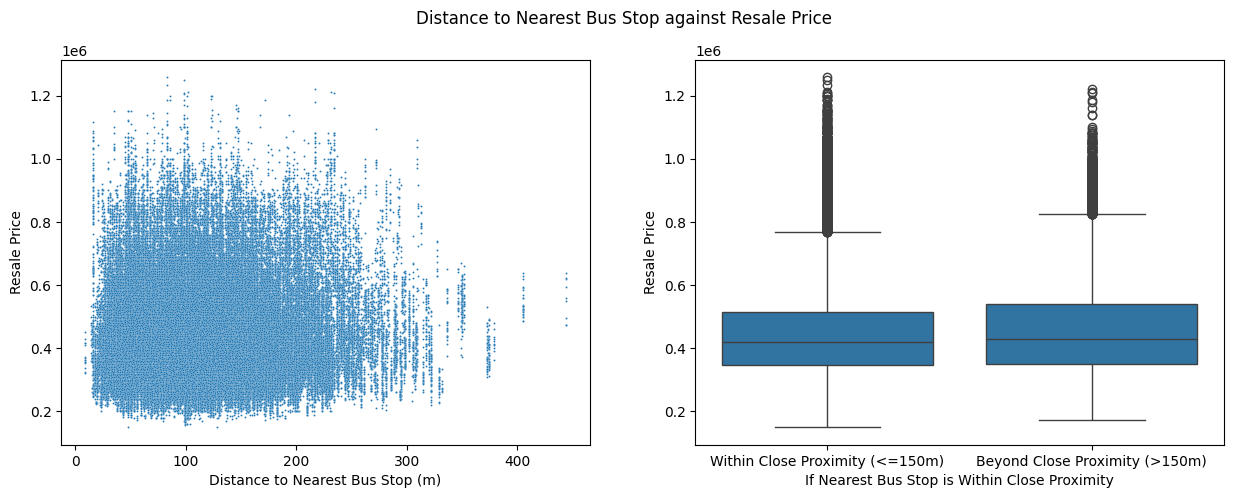

In [22]:
# 1. Display: "Distance to Nearest Bus Stop" Statistics
print("Distance to Nearest Bus Stop (m) (min):", round(df_train["bus_stop_nearest_distance"].min(),0))
print("Distance to Nearest Bus Stop (m) (max):", round(df_train["bus_stop_nearest_distance"].max(),0))
print(f'Distance to Nearest Bus Stop (m) (percentiles): (0.25) {round(df_train["bus_stop_nearest_distance"].quantile(0.25),0)}, (0.5) {round(df_train["bus_stop_nearest_distance"].quantile(0.5),0)}, (0.75) {round(df_train["bus_stop_nearest_distance"].quantile(0.75),0)}', '\n')

# 2. Correlation Coefficient: "Distance to Nearest MRT Station" & "Resale Price"
print("Correlation:\n", df_train[["bus_stop_nearest_distance","resale_price"]].corr())

# 3. Data Visualisation: Scatter & Boxplots
fig, axes = plt.subplots(1, 2, figsize=(15,5), sharey=False)
fig.suptitle("Distance to Nearest Bus Stop against Resale Price")

sns.scatterplot(ax=axes[0], data=df_train, x="bus_stop_nearest_distance", y="resale_price", s=2.0).set(xlabel="Distance to Nearest Bus Stop (m)", ylabel="Resale Price")

df_train["bus_stop_nearest_distance_cat"] = pd.cut(x=df_train["bus_stop_nearest_distance"], bins=[0,150,450], labels=["Within Close Proximity (<=150m)", "Beyond Close Proximity (>150m)"])
sns.boxplot(ax=axes[1], data=df_train, x="bus_stop_nearest_distance_cat", y="resale_price", order=["Within Close Proximity (<=150m)", "Beyond Close Proximity (>150m)"]).set(xlabel="If Nearest Bus Stop is Within Close Proximity", ylabel="Resale Price")

# 4. Display: "Within Close Proximity" Statistics
print("")
print(f'Median Resale Price (Within Close Proximity): {df_train.loc[(df_train["bus_stop_nearest_distance_cat"]=="Within Close Proximity (<=150m)"), ["resale_price"]].median()[0]}')
print(f'Median Resale Price (Beyond Close Proximity): {df_train.loc[(df_train["bus_stop_nearest_distance_cat"]=="Beyond Close Proximity (>150m)"), ["resale_price"]].median()[0]}')


<span style="color: lightblue">

* Observations: 
     * weak positive correlation (0.031), suggesting that closer proximity to a bus stop is associated with <u>lower</u> resale prices 
     * this is also reflected in the slightly higher median resale price of flats beyond close proximity (>150m) ($428,000), compared to those within close proximity (<=150m) ($420,000)
          * *positive correlation might be due to homeowners' preference to stay further away from vehicular traffic that produces vehicular exhaust and noise*

<b> (c) Data Cleaning </b>

1. Check for Missing Values

In [23]:
# Check: Missing Values
for var in ["mrt_nearest_distance", "mrt_interchange", "bus_interchange", "bus_stop_nearest_distance"]:
    print(f"No. of missing values: {df_train[var].isnull().sum()} | var: {var}")

No. of missing values: 0 | var: mrt_nearest_distance
No. of missing values: 0 | var: mrt_interchange
No. of missing values: 0 | var: bus_interchange
No. of missing values: 0 | var: bus_stop_nearest_distance


<b> (d) Feature(s) to Engineer </b>

<span style="color: yellowgreen">

* Nearest MRT Station: (i) within 500m (Walking Distance), (ii) between 500 to 1000m , (iii) beyond 1000m
* Nearest MRT Station: (i) train + bus interchange, (ii) train-only interchange, (iii) bus-only interchange, (iv) not a train/bus interchange
* Nearest Bus Stop: within Close Proximity (150m)


---
<br>
<b> Hypothesis (7) : Accessibility to Amenities is Positively Related to Resale Price </b>

<br> <b> (a) Background </b>

* We hypothesise that accessibility to amenities provided by hawker centers (e.g., food, groceries) and malls (e.g., personal services, retail goods) is associated with higher resale prices.

* In this regard, we wish to explore the relationship between the following features and resale prices: 
    * <b>Proximity to the Nearest Mall</b>: (i) within 500m (Walking Distance), (ii) between 500 to 1000m , (iii) beyond 1000m
    * <b>Apartment Block has Commercial Units</b>
    * <b>Proximity to the Nearest Hawker Centre</b>: (i) within 500m (Walking Distance), (ii) between 500 to 1000m , (iii) beyond 1000m 
    * <b>Nearest Hawker Centre's Size (No. of Food & Market Stalls)</b>: (i) small (<=100 stalls), (ii) large (>100 stalls)

<br> <b> (b-1) Assess : Relationship between "Proximity to the Nearest Mall (Meters)" and "Resale Price" </b>

Distance to Nearest Mall (m) (min): 0.0
Distance to Nearest Mall (m) (max): 3496.0
Distance to Nearest Mall (m) (percentiles): (0.25) 391.0, (0.5) 603.0, (0.75) 869.0 

Correlation:
                        mall_nearest_distance  resale_price
mall_nearest_distance               1.000000     -0.087096
resale_price                       -0.087096      1.000000

Median Resale Price [0,500] - Within Walking Distance: 433000.0
Median Resale Price (500,1000]: 418000.0
Median Resale Price >1000: 393000.0


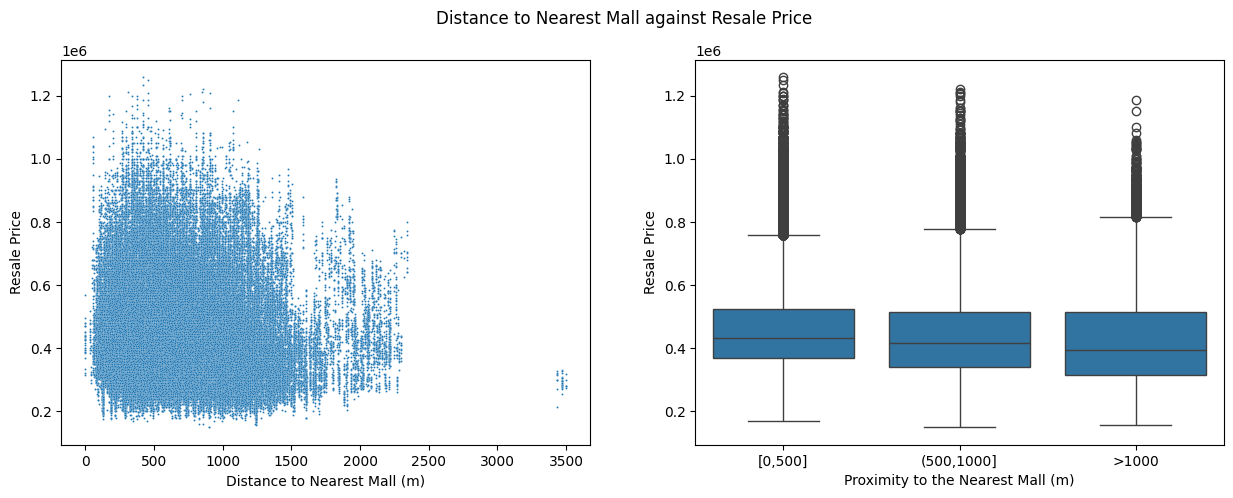

In [24]:
# 1. Display: "Distance to Nearest Mall" Statistics
print("Distance to Nearest Mall (m) (min):", round(df_train["mall_nearest_distance"].min(),0))
print("Distance to Nearest Mall (m) (max):", round(df_train["mall_nearest_distance"].max(),0))
print(f'Distance to Nearest Mall (m) (percentiles): (0.25) {round(df_train["mall_nearest_distance"].quantile(0.25),0)}, (0.5) {round(df_train["mall_nearest_distance"].quantile(0.5),0)}, (0.75) {round(df_train["mall_nearest_distance"].quantile(0.75),0)}', '\n')

# 2. Correlation Coefficient: "Distance to Nearest MRT Station" & "Resale Price"
print("Correlation:\n", df_train[["mall_nearest_distance","resale_price"]].corr())

# 3. Data Visualisation: Scatter & Boxplots
fig, axes = plt.subplots(1, 2, figsize=(15,5), sharey=False)
fig.suptitle("Distance to Nearest Mall against Resale Price")

sns.scatterplot(ax=axes[0], data=df_train, x="mall_nearest_distance", y="resale_price", s=2.0).set(xlabel="Distance to Nearest Mall (m)", ylabel="Resale Price")

df_train["mall_nearest_distance_cat"] = pd.cut(x=df_train["mall_nearest_distance"], bins=[0,500,1000,3600], labels=["[0,500]", "(500,1000]", ">1000"])
sns.boxplot(ax=axes[1], data=df_train, x="mall_nearest_distance_cat", y="resale_price", order=["[0,500]", "(500,1000]", ">1000"]).set(xlabel="Proximity to the Nearest Mall (m)", ylabel="Resale Price")

# 4. Display: "Proximity to the Nearest Mall" Statistics
print("")
print(f'Median Resale Price [0,500] - Within Walking Distance: {df_train.loc[(df_train["mall_nearest_distance_cat"]=="[0,500]"), ["resale_price"]].median()[0]}')
print(f'Median Resale Price (500,1000]: {df_train.loc[(df_train["mall_nearest_distance_cat"]=="(500,1000]"), ["resale_price"]].median()[0]}')
print(f'Median Resale Price >1000: {df_train.loc[(df_train["mall_nearest_distance_cat"]==">1000"), ["resale_price"]].median()[0]}')


<span style="color: lightblue">

* Observations: 
     * Expectedly negative correlation (-0.087) between distance to nearest mall and resale price, albeit marginal
     * This is also reflected in the higher median resale price of flats within walking distance to the nearest mall (<=500m) ($433,000), compared to those beyond walking distance (500-1000m: $410,000; >1000: $393,000)
     * Wide variation in prices by distance to nearest mall - suggesting presence of other factors influencing resale prices

<br> <b> (b-2) Assess : Relationship between "Apartment Block has Commercial Units" and "Resale Price" </b>

Apartment Block has Commercial Units (mean): 0.191
Correlation:
               commercial_y  resale_price
commercial_y      1.000000     -0.140183
resale_price     -0.140183      1.000000



Median Resale Price [0:No]: 430000.0
Median Resale Price [1:Yes]: 382000.0


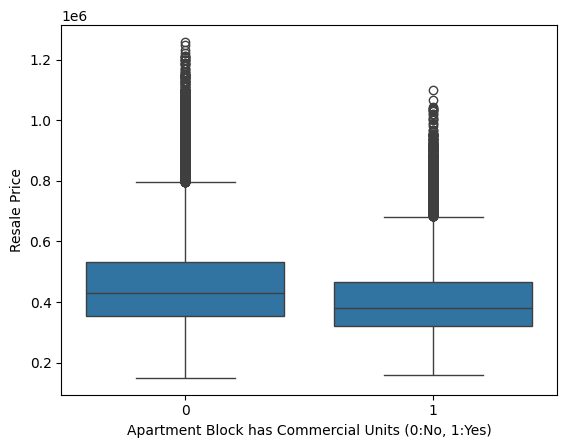

In [25]:
# 1. Convert "Apartment Block has Commercial Units" column to Numeric Type
df_train["commercial_y"] =  df_train["commercial"].map({"Y":1, "N":0})

# 2. Display: "Apartment Block has Commercial Units" Statistics
print("Apartment Block has Commercial Units (mean):", round(df_train["commercial_y"].mean(),3))

# 3. Correlation Coefficient: "Apartment Block has Commercial Units" & "Resale Price"
print("Correlation:\n", df_train[["commercial_y","resale_price"]].corr())

# 4. Data Visualisation: Boxplots
sns.boxplot(data=df_train, x="commercial_y", y="resale_price", order=[0,1]).set(xlabel="Apartment Block has Commercial Units (0:No, 1:Yes)", ylabel="Resale Price")

# 5. Display: "Apartment Block has Commercial Units" Statistics
print("")
print(f'Median Resale Price [0:No]: {df_train.loc[(df_train["commercial_y"]==0), ["resale_price"]].median()[0]}')
print(f'Median Resale Price [1:Yes]: {df_train.loc[(df_train["commercial_y"]==1), ["resale_price"]].median()[0]}')


<span style="color: lightblue">

* Observations: 
     * Unexpected negative correlation (-0.140) between whether an apartment block has commercial units and resale price 
     * This is also reflected in the lower median resale price of flats within apartment blocks with commercial units ($382,000), compared to those without ($430,000)
          * This might be due to confounding factors (e.g., shorter remaining lease periods - as commerical units at the foot of blocks tend to be a feature of mature estates), which will need to be controlled for subsequently*
     * Wide variation in prices by whether the apartment block has commercial units - suggesting presence of other factors influencing resale prices

<br> <b> (b-3) Assess : Relationship between "Proximity to the Nearest Hawker Centre (Meters)" and "Resale Price" </b>

Distance to Hawker Centre (m) (min): 2.0
Distance to Hawker Centre (m) (max): 4907.0
Distance to Hawker Centre (m) (percentiles): (0.25) 372.0, (0.5) 779.0, (0.75) 1679.0 

Correlation:
                          hawker_nearest_distance  resale_price
hawker_nearest_distance                 1.000000     -0.014537
resale_price                           -0.014537      1.000000



Median Resale Price [0,500] - Within Walking Distance: 390000.0
Median Resale Price (500,1000]: 420000.0
Median Resale Price >1000: 432500.0


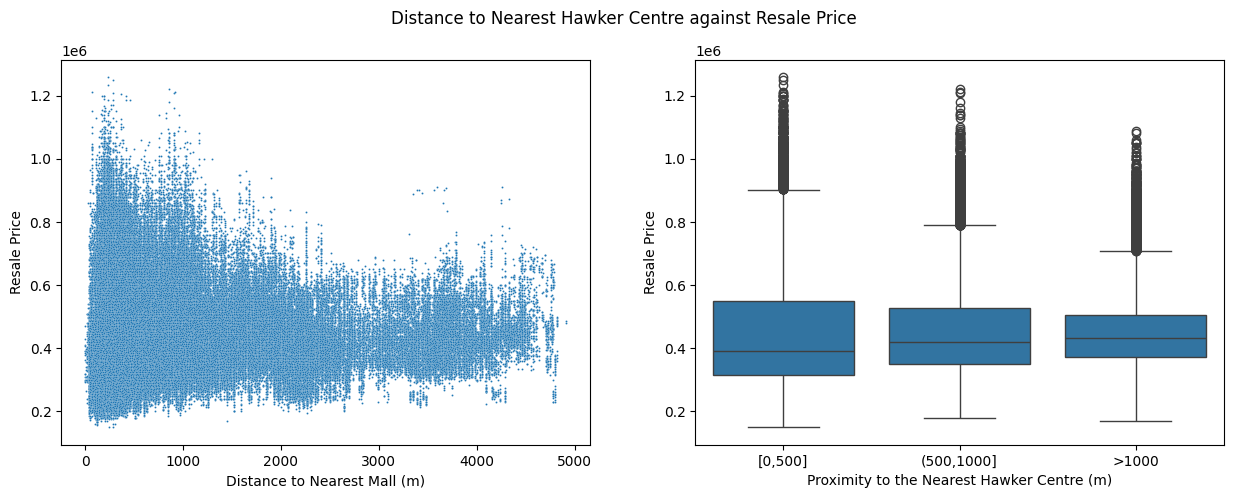

In [26]:
# 1. Display: "Distance to Nearest Hawker Centre" Statistics
print("Distance to Hawker Centre (m) (min):", round(df_train["hawker_nearest_distance"].min(),0))
print("Distance to Hawker Centre (m) (max):", round(df_train["hawker_nearest_distance"].max(),0))
print(f'Distance to Hawker Centre (m) (percentiles): (0.25) {round(df_train["hawker_nearest_distance"].quantile(0.25),0)}, (0.5) {round(df_train["hawker_nearest_distance"].quantile(0.5),0)}, (0.75) {round(df_train["hawker_nearest_distance"].quantile(0.75),0)}', '\n')

# 2. Correlation Coefficient: "Distance to Nearest Hawker Centre" & "Resale Price"
print("Correlation:\n", df_train[["hawker_nearest_distance","resale_price"]].corr())

# 3. Data Visualisation: Scatter & Boxplots
fig, axes = plt.subplots(1, 2, figsize=(15,5), sharey=False)
fig.suptitle("Distance to Nearest Hawker Centre against Resale Price")

sns.scatterplot(ax=axes[0], data=df_train, x="hawker_nearest_distance", y="resale_price", s=2.0).set(xlabel="Distance to Nearest Mall (m)", ylabel="Resale Price")

df_train["hawker_nearest_distance_cat"] = pd.cut(x=df_train["hawker_nearest_distance"], bins=[0,500,1000,3600], labels=["[0,500]", "(500,1000]", ">1000"])
sns.boxplot(ax=axes[1], data=df_train, x="hawker_nearest_distance_cat", y="resale_price", order=["[0,500]", "(500,1000]", ">1000"]).set(xlabel="Proximity to the Nearest Hawker Centre (m)", ylabel="Resale Price")

# 4. Display: "Proximity to the Nearest Hawker Centre" Statistics
print("")
print(f'Median Resale Price [0,500] - Within Walking Distance: {df_train.loc[(df_train["hawker_nearest_distance_cat"]=="[0,500]"), ["resale_price"]].median()[0]}')
print(f'Median Resale Price (500,1000]: {df_train.loc[(df_train["hawker_nearest_distance_cat"]=="(500,1000]"), ["resale_price"]].median()[0]}')
print(f'Median Resale Price >1000: {df_train.loc[(df_train["hawker_nearest_distance_cat"]==">1000"), ["resale_price"]].median()[0]}')


<span style="color: lightblue">

* Observations: 
     * Unexpected negative correlation (-0.015) between distance to nearest hawker centre and resale price, albeit marginal
     * Lower median resale price of flats within walking distance to the nearest hawker centre (<=500m) ($390,000), compared to those beyond walking distance (500-1000m: $420,000; >1000: $432,500) appears counter-intuitive
          * *This might be due to confounding factors (e.g., shorter remaining lease periods, smaller flat sizes - as hawker centres tend to be located in mature estates), which will need to be controlled for subsequently*
     * Wide variation in prices by distance to nearest hawker centre - suggesting presence of other factors influencing resale prices

<br> <b> (b-4) Assess : Relationship between "Nearest Hawker Centre's Size (No. of Food & Market Stalls)" and "Resale Price" </b>

Nearest Hawker Centre Size (min): 21
Nearest Hawker Centre Size (max): 703
Nearest Hawker Centre Size (percentiles): (0.25) 42.0, (0.5) 94.0, (0.75) 160.0 

Correlation:
                              hawker_food_market_stalls_n  resale_price
hawker_food_market_stalls_n                      1.00000      -0.01813
resale_price                                    -0.01813       1.00000



Median Resale Price [Small (<=100)]: 430000.0
Median Resale Price [Large (>100)]: 407000.0


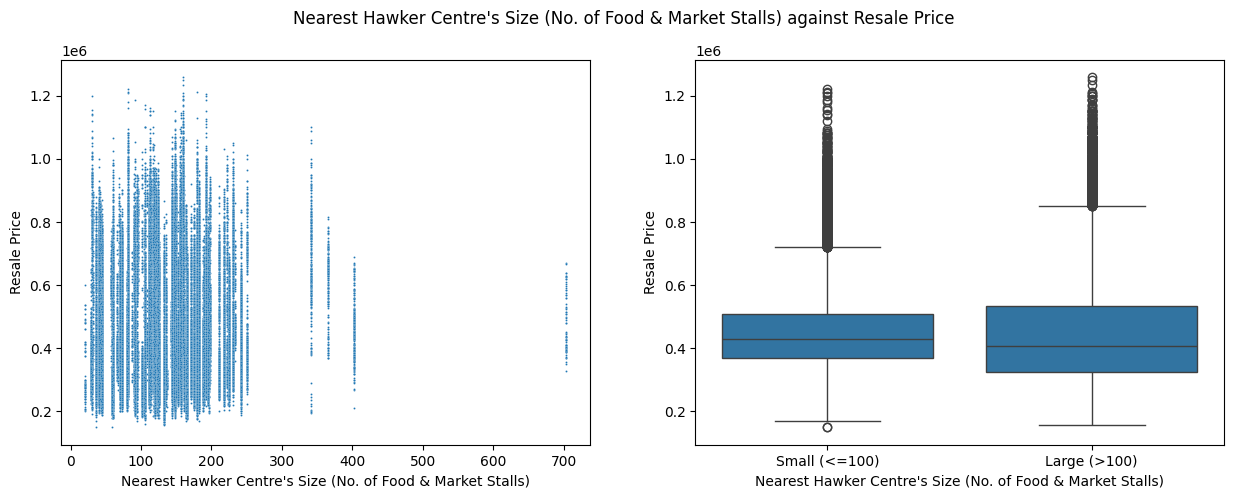

In [27]:
# 1. Add: "Nearest Hawker Centre's Size (No. of Food & Market Stalls)"
df_train["hawker_food_market_stalls_n"] = df_train["hawker_food_stalls"] + df_train["hawker_market_stalls"]

# 2. Display: "Nearest Hawker Centre's Size (No. of Food & Market Stalls)" Statistics
print("Nearest Hawker Centre Size (min):", round(df_train["hawker_food_market_stalls_n"].min(),0))
print("Nearest Hawker Centre Size (max):", round(df_train["hawker_food_market_stalls_n"].max(),0))
print(f'Nearest Hawker Centre Size (percentiles): (0.25) {round(df_train["hawker_food_market_stalls_n"].quantile(0.25),0)}, (0.5) {round(df_train["hawker_food_market_stalls_n"].quantile(0.5),0)}, (0.75) {round(df_train["hawker_food_market_stalls_n"].quantile(0.75),0)}', '\n')

# Note: Max of 700+ food and hawker stalls is not a data error – but likely refers to Chinatown Complex Market
# Link: https://www.nea.gov.sg/our-services/hawker-management/programmes-and-grants/heritage-of-our-hawker-centres

# 3. Correlation Coefficient: "Nearest Hawker Centre's Size (No. of Food & Market Stalls)" & "Resale Price"
print("Correlation:\n", df_train[["hawker_food_market_stalls_n","resale_price"]].corr())

# 4. Data Visualisation: Scatter & Boxplots
fig, axes = plt.subplots(1, 2, figsize=(15,5), sharey=False)
fig.suptitle("Nearest Hawker Centre's Size (No. of Food & Market Stalls) against Resale Price")

sns.scatterplot(ax=axes[0], data=df_train, x="hawker_food_market_stalls_n", y="resale_price", s=2.0).set(xlabel="Nearest Hawker Centre's Size (No. of Food & Market Stalls)", ylabel="Resale Price")

df_train["hawker_food_market_stalls_cat"] = pd.cut(x=df_train["hawker_food_market_stalls_n"], bins=[0,100,800], labels=["Small (<=100)", "Large (>100)"])
sns.boxplot(ax=axes[1], data=df_train, x="hawker_food_market_stalls_cat", y="resale_price", order=["Small (<=100)", "Large (>100)"]).set(xlabel="Nearest Hawker Centre's Size (No. of Food & Market Stalls)", ylabel="Resale Price")
# Note: Cutoff of 100 stalls used as this is close to the median size

# 5. Display: "Nearest Hawker Centre's Size (No. of Food & Market Stalls)" Statistics
print("")
print(f'Median Resale Price [Small (<=100)]: {df_train.loc[(df_train["hawker_food_market_stalls_cat"]=="Small (<=100)"), ["resale_price"]].median()[0]}')
print(f'Median Resale Price [Large (>100)]: {df_train.loc[(df_train["hawker_food_market_stalls_cat"]=="Large (>100)"), ["resale_price"]].median()[0]}')


<span style="color: lightblue">

* Observations: 
     * Unexpected negative correlation (-0.018) between nearest hawker centre's size (no. of food & market stalls) and resale price, albeit marginal
     * Lower median resale price of flats with large nearest hawker centres ($407,000), compared to those with small nearest hawker centres ($430,000) appears counter-intuitive
          * *This might be due to confounding factors (e.g., shorter remaining lease periods, smaller flat sizes - as large hawker centres tend to be located in mature estates), which will need to be controlled for subsequently*
     * Wide variation in prices by size of nearest hawker centre - suggesting presence of other factors influencing resale prices

<b> (c) Data Cleaning </b>

1. Check for Missing Values

In [28]:
# Check: Missing Values
for var in ["mall_nearest_distance", "commercial","hawker_nearest_distance", "hawker_food_stalls", "hawker_market_stalls"]:
    print(f"No. of missing values: {df_train[var].isnull().sum()} | var: {var}")

No. of missing values: 829 | var: mall_nearest_distance
No. of missing values: 0 | var: commercial
No. of missing values: 0 | var: hawker_nearest_distance
No. of missing values: 0 | var: hawker_food_stalls
No. of missing values: 0 | var: hawker_market_stalls


<span style="color: yellowgreen">

* Row-wise deletion of these observations will be performed, since missing values related to "distance to nearest mall" form an insignificant proportion of all observations (~0.6%)

<b> (d) Feature(s) to Engineer </b>

<span style="color: yellowgreen">

* Proximity to the Nearest Mall: (i) within 500m (Walking Distance), (ii) between 500 to 1000m , (iii) beyond 1000m
* Proximity to the Nearest Hawker Centre: (i) within 500m (Walking Distance), (ii) between 500 to 1000m , (iii) beyond 1000m
* Nearest Hawker Centre's Size (No. of Food & Market Stalls): (i) small (<=100 stalls), (ii) large (>100 stalls)


---
<br>
<b> Hypothesis (8) : Unobserved Area Based Features Are Associated with Resale Price </b>

<br> <b> (a) Background </b>

* We hypothesize that there are area-based features that are unobserved (i.e., not within our feature set), but which influence resale prices. These include characteristics such as:

    * Air Quality 
        * (i.e., with industrial towns such as Jurong having lower air quality)
    * Natural Amenities 
        * (e.g., parks, proximity to the sea)
    * Intangible Character & Unobserved Amenities 
        * (e.g., Katong: 'Steeped in Peranakan and Eurasian heritage… lined with trendy shops and cafes that make the area a favourite hangout on weekends, plus bars and restaurants that make it ideal for a fun night out' – [link]( https://www.edb.gov.sg/en/business-insights/insights/moving-to-singapore-which-neighbourhood-is-for-you.html))

<br> <b> (b) Assess : Relationship between "Towns" and "Resale Prices" </b>

* Preliminarily, and prior to performing regression analyses that will control for observable differences across towns, this section explores variation in resale prices by town - to identify towns that tend to command higher resale prices

C:\Users\joell\AppData\Local\Temp\ipykernel_1896\1499972922.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_train, y="resale_price", x="town", order=town_list, palette=pal).set(xlabel="Town", ylabel="Resale Price")


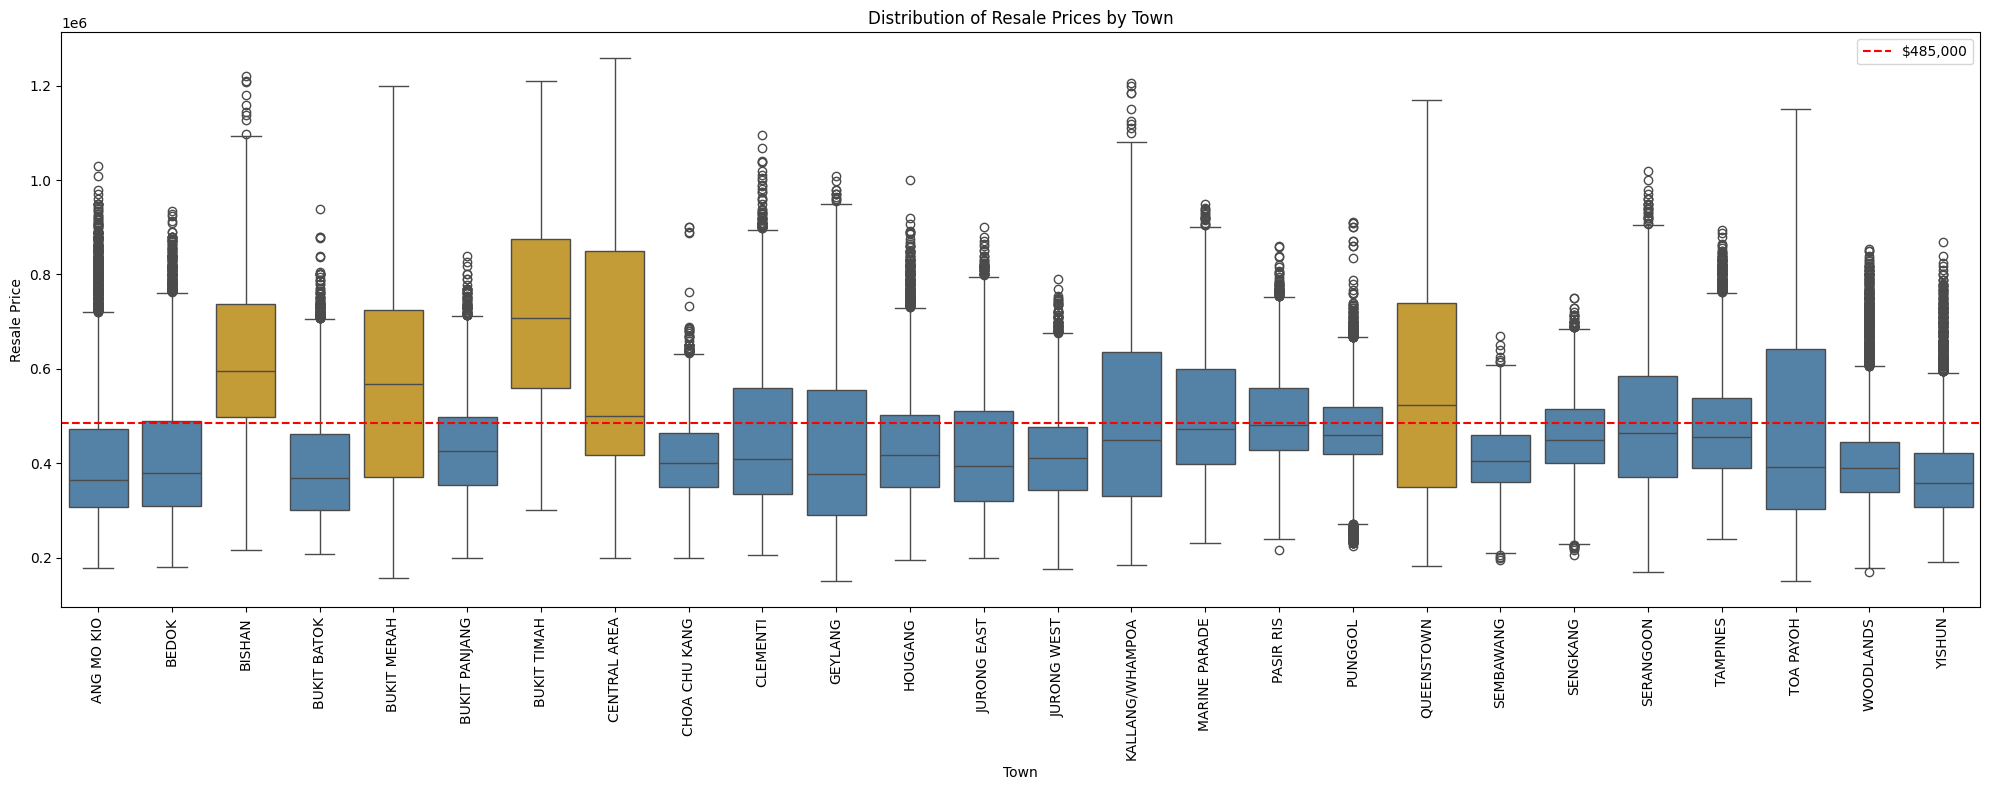

In [29]:
# Add: List of Towns (By Alphabetical Order)
town_list = [town for town in df_train["town"].unique()]
town_list.sort()

# Display: Distribution of Resale Prices by Town
plt.figure(figsize=(20,8))

pal = {town:"goldenrod" 
        if (town=="BISHAN" or town=="BUKIT MERAH" or town=="BUKIT TIMAH" or town=="CENTRAL AREA" or town=="QUEENSTOWN") 
        else "steelblue" for town in town_list}

sns.boxplot(data=df_train, y="resale_price", x="town", order=town_list, palette=pal).set(xlabel="Town", ylabel="Resale Price")

plt.axhline(y=485000, color='red', linestyle='--', label="$485,000")
plt.legend()

plt.title("Distribution of Resale Prices by Town")
plt.xticks(rotation=90)
plt.tight_layout()


<span style="color: lightblue">

* Observations: 
     * Median resale prices in “Bishan”, “Bukit Merah”, “Bukit Timah”, “Central Area” and “Queenstown” tend to be higher than other towns, based on a cutoff of $485,000
     * This might be due in part to unobserved area characteristics – which will be investigated subsequently through regression analyses 

<b> (c) Data Cleaning </b>

1. Check for Missing Values

In [30]:
# Check: Missing Values
print(f'No. of missing values: {df_train["town"].isnull().sum()}')

No. of missing values: 0


<b> (d) Feature(s) to Engineer </b>

<span style="color: yellowgreen">

* Town Dummies (excluding a reference town)



---
<br>
<b> Hypothesis (9) : Time-based Events Are Associated with Resale Prices </b>

<br> <b> (a) Background </b>

* We hypothesize that time-based events (e.g., general inflation, property market demand/supply shifts (such as halting of construction activity over the covid period - [link](https://www.straitstimes.com/singapore/suspending-all-construction-work-to-stem-coronavirus-spread-is-a-difficult-trade-off)), influence resale prices. 

<br> <b> (b) Assess : Relationship between "Year" and "Resale Prices" </b>

* Preliminarily, and prior to performing regression analyses that will control for observable differences across years, this section explores variation in resale prices by year - to examine the trend in resale prices over time

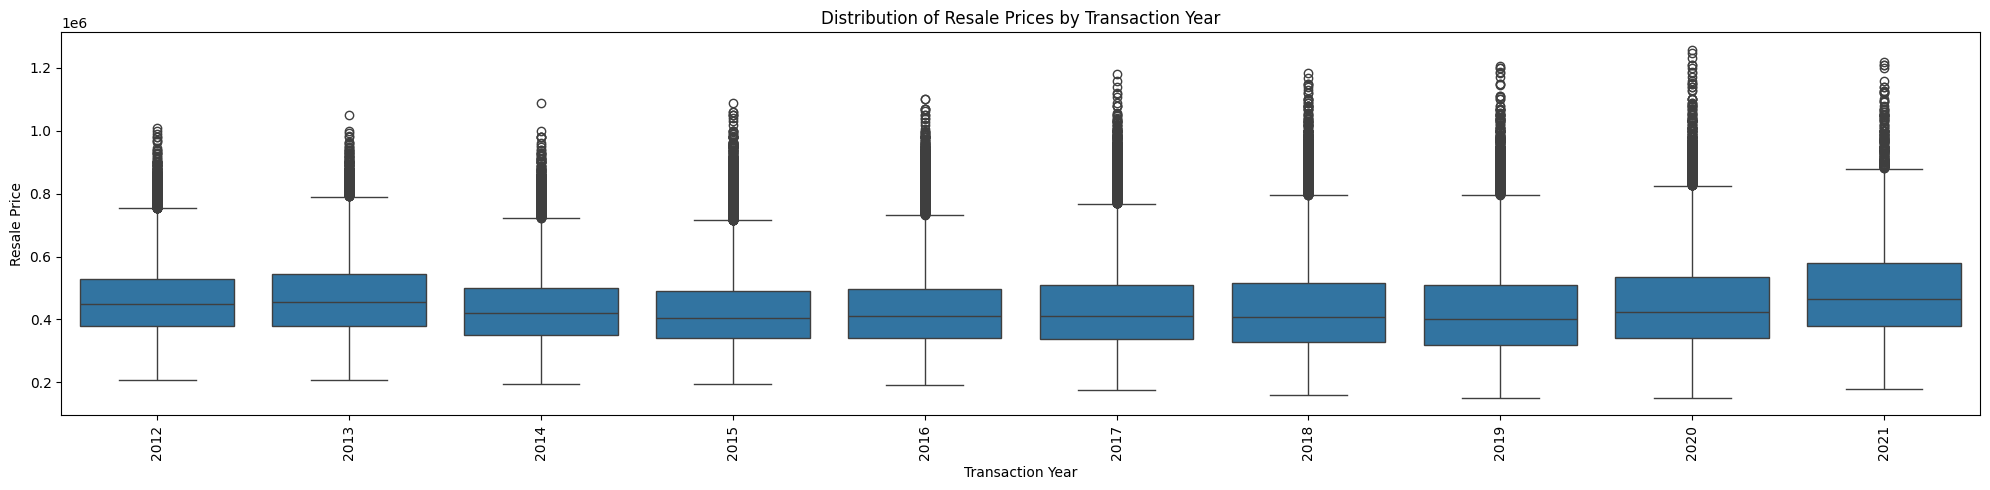

In [31]:
# Add: List of Towns (By Alphabetical Order)
tranc_year_list = [year for year in df_train["tranc_year"].unique()]
tranc_year_list.sort()

# Display: Distribution of Resale Prices by Year
plt.figure(figsize=(20,5))
sns.boxplot(data=df_train, y="resale_price", x="tranc_year", order=tranc_year_list).set(xlabel="Transaction Year", ylabel="Resale Price")
plt.title("Distribution of Resale Prices by Transaction Year")
plt.xticks(rotation=90)
plt.tight_layout()

<span style="color: lightblue">

* Observations: 
     * Slight variation in median resale prices by transaction year – suggesting possible year-specific effects

<b> (c) Data Cleaning </b>

1. Check for Missing Values

In [32]:
# Check: Missing Values
print(f'No. of missing values: {df_train["tranc_year"].isnull().sum()}')

No. of missing values: 0


<b> (d) Feature(s) to Engineer </b>

<span style="color: yellowgreen">

* Transaction year dummies (excluding a reference year)


---
<br>
<b> Hypothesis (10) : Lower Travelling Cost to the Central Business District (CBD) via the MRT Network is Positively Associated with Resale Price </b>

<br> <b> (a) Background </b>

* Hypothesis
    * HDB residents tend to travel by the MRT, and there's a premium (penalty) to being closer (further) away from the Central Business District (CBD) in terms of distance travelled along the MRT network
    * This premium may be due to the added convenience of accessing job opportunities in the CBD, as well as higher rental income potential for homeowners

* Measuring Travel Cost to the CBD via the MRT Network
    * Travel Cost = Minimum(Number of MRT stations away from a CBD station + Transfer Penalty for Switching MRT Lines)
        * 'Transfer Penalty' considered as time is required to travel between train platforms, wait for a connecting train

<b> (b) Feature(s) to Engineer </b>

<span style="color: yellowgreen">

* Travel Cost to the CBD via the MRT Network


---
<br>
<b> Hypothesis (11) : Accessibility to 'Branded' Schools is Positively Associated with Resale Price </b>

<br> <b> (a) Background </b>

We hypothesize that homeowners value being located near "branded/elite" schools, for the following reasons.

* In the context of <b>primary schools</b>:
    * Priority for admission into a given primary school is based on proximity, with children living (a) within 1km of the school being granted higher priority than those living (b) between 1km - 2km, and (c) beyond 2km
        * Ministry of Education. (n.d.). How Distance Affects Priority Admission. [link](https://www.moe.gov.sg/primary/p1-registration/distance)
    * Given competition for places in "branded/elite" schools, parents may be willing to pay a premium to purchase homes near these schools, to increase chances of their children being granted admission to these schools
    * In this regard, property analysts estimate that being located close to a "branded/elite" school could raise home prices by 10-15%
        * Channel News Asia (2023). Prices of Tengah Homes near ACS (Primary) could Rise 10% to 15%: Property Analysts. [link](https://www.channelnewsasia.com/singapore/acs-primary-tengah-property-prices-school-relocate-3265786)

* In the context of <b>secondary schools</b>:
    * Proximity-based priority admission <u>does not</u> feature as a factor that may influence home prices - as admissions are based on national examination scores and other criteria unrelated to proximity to the school
    * Hence, it is currently less certain if proximity to "branded/elite" secondary schools influences home prices

<b> (b) Feature(s) to Engineer </b>

<span style="color: yellowgreen">

* Number of ‘Branded’ primary schools: (a) within 1 km, (b) between 1km to 2km
* Number of ‘Branded’ secondary schools: (a) within 1 km, (b) between 1km to 2km

<br>


---

#### <b> Part 4: Summary of Data Processing Next Steps </b>

<b>(a) Data Cleaning </b>

* <b>Floor Area</b>: Exclude outliers by “Flat Type-Model”

* <b>Accessibility to Amenities</b>: Perform row-wise deletion of observations with missing values related to "distance to nearest mall", since these form an insignificant proportion of all observations (~0.6%)

<b> (b) Feature Engineering </b>

* <b>Floor Area</b>: (Floor Area)^2
* <b>Floor Level</b>: (Floor Level)^2
* <b>Exceptional Flat Types</b>: "DBSS", "Terrace", "Mansionette/Loft", "Duxton S-Type" Dummies
* <b>Remaining Lease Period</b>: (Remaining Lease Period)^2

* <b>Apartment's Neighbour Composition</b>
    * (a) If Apartment Block has Rental Units

* <b>Accessibility to Transport Infrastructure</b>: 
    * (a) Nearest MRT Station: (i) within 500m (Walking Distance), (ii) between 500 to 1000m , (iii) beyond 1000m
    * (b) Nearest MRT Station: (i) train + bus interchange, (ii) train-only interchange, (iii) bus-only interchange, (iv) not a train/bus interchange 
    * (c) Nearest Bus Stop within Close Proximity (150m)

* <b>Accessibility to Amenities</b>: 
    * (a) Nearest Mall: (i) within 500m (Walking Distance), (ii) between 500 to 1000m , (iii) beyond 1000m
    * (b) Nearest Hawker Centre: (i) within 500m (Walking Distance), (ii) between 500 to 1000m , (iii) beyond 1000m
    * (c) Nearest Hawker Centre's Size (No. of Food & Market Stalls): (i) small (<=100 stalls), (ii) large (>100 stalls)

* <b>Unobserved Area-based Features</b>: “Town” Dummies
* <b>Time-based Events</b>: “Transaction Year” Dummies

* <b>Accessibility to the CBD</b>: Travel Cost to the CBD via the MRT Network

* <b>Accessibility to ‘Branded’ Schools</b>: 
    * (a) Number of ‘Branded’ primary schools: (i) within 1 km, (ii) between 1km to 2km
    * (b) Number of ‘Branded’ secondary schools: (i) within 1 km, (ii) between 1km to 2km



---